In [1]:
!pwd
import sys
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sys.executable

/c/Users/81908/jupyter_notebook/tf_2_work/Probspace_geme_compe/notebook


'C:\\Users\\81908\\Anaconda3\\envs\\tfgpu\\python.exe'

# 対戦ゲームデータ分析甲子園
- https://prob.space/competitions/game_winner/data/62

In [2]:
import os
import gc
import sys
import joblib
import warnings
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import optuna
from joblib import Parallel, delayed
from sklearn import preprocessing
from sklearn.feature_selection import RFECV, RFE
from sklearn.inspection import permutation_importance
from sklearn.model_selection import *
from sklearn.metrics import *
import lightgbm as lgb
from lightgbm import *

sys.path.append(r"C:\Users\81908\Git\xfeat")
import xfeat
from xfeat import *
from xfeat.selector import *
from xfeat.utils import compress_df

sns.set()
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

In [3]:
OUT_DATA = r"C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\data\feature_eng"
os.makedirs(OUT_DATA, exist_ok=True)

ORIG = r"C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\data\orig"
train_df = pd.read_csv(f"{ORIG}/train_data.csv")
test_df = pd.read_csv(f"{ORIG}/test_data.csv")
df_all = train_df.append(test_df).reset_index(drop=True)

## test用
#train_df = train_df.head(1000)
#test_df = test_df.head(100)
#df_all = train_df.append(test_df).reset_index(drop=True)

# データ確認

In [4]:
def df_info(df):
    df.info()
    display(df.head().style.background_gradient(cmap="Pastel1"))
    display(df.describe().T.style.background_gradient(cmap="Pastel1"))

    # カラム名 / カラムごとのユニーク値数 / 最も出現頻度の高い値 / 最も出現頻度の高い値の出現回数 / 欠損損値の割合 / 最も多いカテゴリの割合 / dtypes を表示
    stats = []
    for col in df.columns:
        stats.append(
            (
                col,
                df[col].nunique(),
                df[col].value_counts().index[0],
                df[col].value_counts().values[0],
                df[col].isnull().sum() * 100 / df.shape[0],
                df[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                df[col].dtype,
            )
        )
    stats_df = pd.DataFrame(
        stats,
        columns=[
            "Feature",
            "Unique values",
            "Most frequent item",
            "Freuquence of most frequent item",
            "Percentage of missing values",
            "Percentage of values in the biggest category",
            "Type",
        ],
    )
    display(stats_df.sort_values("Percentage of missing values", ascending=False).style.background_gradient(cmap="Pastel1"))

In [5]:
df_info(df_all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94465 entries, 0 to 94464
Data columns (total 32 columns):
A1-level      94465 non-null int64
A1-rank       73749 non-null object
A1-weapon     94465 non-null object
A2-level      94465 non-null float64
A2-rank       73749 non-null object
A2-weapon     94465 non-null object
A3-level      94465 non-null float64
A3-rank       73749 non-null object
A3-weapon     94465 non-null object
A4-level      94399 non-null float64
A4-rank       73698 non-null object
A4-weapon     94399 non-null object
B1-level      94465 non-null int64
B1-rank       73749 non-null object
B1-weapon     94465 non-null object
B2-level      94465 non-null float64
B2-rank       73749 non-null object
B2-weapon     94465 non-null object
B3-level      94463 non-null float64
B3-rank       73748 non-null object
B3-weapon     94463 non-null object
B4-level      94368 non-null float64
B4-rank       73667 non-null object
B4-weapon     94368 non-null object
game-ver      94465 non

,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,game-ver,id,lobby,lobby-mode,mode,period,stage,y
0,139,nan,sshooter_becchu,118,nan,soytuber_custom,13,nan,pablo_hue,10,nan,hokusai,28,nan,bold_7,26,nan,hokusai_becchu,68,nan,herocharger_replica,31,nan,sharp_neo,5.0.1,1,standard,regular,nawabari,2019-10-15T20:00:00+00:00,sumeshi,1
1,198,nan,parashelter_sorella,77,nan,jetsweeper,198,nan,campingshelter_camo,123,nan,nzap85,83,nan,momiji,118,nan,squiclean_b,168,nan,campingshelter,151,nan,sputtery_clear,5.0.1,2,standard,regular,nawabari,2019-12-14T04:00:00+00:00,arowana,0
2,114,a-,nzap89,68,a,quadhopper_black,225,a,prime_becchu,107,a,jetsweeper,50,a-,bold_7,163,a+,nzap85,160,a-,prime_becchu,126,a,dualsweeper_custom,5.0.1,3,standard,gachi,hoko,2019-12-25T14:00:00+00:00,ama,0
3,336,nan,bamboo14mk1,131,nan,splatroller_becchu,189,nan,dynamo_tesla,41,nan,prime_becchu,273,nan,splatcharger_becchu,189,nan,liter4k,194,nan,promodeler_mg,391,nan,hotblaster_custom,5.0.1,4,standard,regular,nawabari,2019-11-11T14:00:00+00:00,engawa,0
4,299,x,bold_7,97,x,hissen_hue,96,x,h3reelgun_d,136,x,splatroller,101,x,furo,45,x,sputtery_hue,246,x,bucketslosher_soda,160,x,wakaba,5.0.1,5,standard,gachi,hoko,2019-12-14T06:00:00+00:00,chozame,1


,count,mean,std,min,25%,50%,75%,max
A1-level,94465,208.714,118.848,1,120,188,277,585
A2-level,94465,155.143,96.0964,1,82,139,208,913
A3-level,94465,153.007,95.4316,1,80,136,205,920
A4-level,94399,155.815,95.4638,1,84,139,208,933
B1-level,94465,156.598,97.3104,1,83,139,210,920
B2-level,94465,152.767,95.3817,1,80,136,205,931
B3-level,94463,153.119,94.8847,1,81,137,205,933
B4-level,94368,157.186,95.396,1,85,141,210,936
id,94465,27395.2,18711,1,11809,23617,42509,66125
y,66125,0.524703,0.499393,0,0,1,1,1


,Feature,Unique values,Most frequent item,Freuquence of most frequent item,Percentage of missing values,Percentage of values in the biggest category,Type
31,y,2,1,34696,30.0005,36.7289,float64
22,B4-rank,12,x,35278,22.0166,37.345,object
10,A4-rank,12,x,35291,21.9838,37.3588,object
19,B3-rank,12,x,35319,21.9309,37.3885,object
7,A3-rank,12,x,35319,21.9298,37.3885,object
1,A1-rank,12,x,35319,21.9298,37.3885,object
13,B1-rank,12,x,35319,21.9298,37.3885,object
16,B2-rank,12,x,35319,21.9298,37.3885,object
4,A2-rank,12,x,35319,21.9298,37.3885,object
23,B4-weapon,139,splatroller,4802,0.102684,5.08336,object


# 前処理

In [6]:
# 重複レコード確認して消す
_df = train_df.drop(["id"], axis=1)
_df_dup = _df[_df.duplicated()]
display(_df_dup)

# 重複レコード削除
print(train_df.shape)
train_df = train_df[~train_df.drop(["id"], axis=1).duplicated()].reset_index(drop=True)
print(train_df.shape)
df_all = train_df.append(test_df).reset_index(drop=True)

,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,A2-weapon,A2-rank,A2-level,A3-weapon,A3-rank,A3-level,A4-weapon,A4-rank,A4-level,B1-weapon,B1-rank,B1-level,B2-weapon,B2-rank,B2-level,B3-weapon,B3-rank,B3-level,B4-weapon,B4-rank,B4-level,y
7221,2019-12-02T04:00:00+00:00,5.0.1,gachi,standard,asari,ama,bamboo14mk1,x,78,l3reelgun,x,140.0,maneuver_collabo,x,150.0,splatcharger_becchu,x,231.0,hotblaster_custom,x,130,96gal,x,232.0,pablo,x,161.0,splatscope_becchu,x,348.0,1
7967,2019-12-02T00:00:00+00:00,5.0.1,regular,standard,nawabari,arowana,96gal,NaN,78,dynamo_becchu,NaN,67.0,squiclean_g,NaN,127.0,variableroller,NaN,54.0,kelvin525,NaN,94,clashblaster,NaN,51.0,splatroller,NaN,55.0,bamboo14mk3,NaN,105.0,1
32868,2019-12-02T02:00:00+00:00,5.0.1,gachi,standard,yagura,shottsuru,bamboo14mk1,x,78,longblaster_necro,x,127.0,screwslosher_becchu,x,389.0,parashelter_sorella,x,45.0,splatroller,x,171,hotblaster_custom,x,96.0,barrelspinner_remix,x,167.0,bottlegeyser_foil,x,392.0,1
35812,2019-12-25T12:00:00+00:00,5.0.1,regular,standard,nawabari,devon,nzap83,NaN,215,bamboo14mk1,NaN,130.0,wakaba,NaN,58.0,sshooter,NaN,59.0,promodeler_mg,NaN,94,momiji,NaN,177.0,jetsweeper,NaN,48.0,squiclean_b,NaN,139.0,1
35934,2019-12-02T02:00:00+00:00,5.0.1,gachi,standard,yagura,chozame,rapid_becchu,x,78,sharp_neo,x,432.0,nzap85,x,142.0,l3reelgun_d,x,198.0,prime_becchu,x,165,sharp_neo,x,385.0,nzap85,x,69.0,screwslosher_becchu,x,137.0,1
37649,2019-12-25T12:00:00+00:00,5.0.1,regular,standard,nawabari,devon,nzap83,NaN,215,maneuver_collabo,NaN,165.0,campingshelter,NaN,135.0,hydra_custom,NaN,84.0,bold_neo,NaN,64,bold_7,NaN,257.0,splatroller,NaN,93.0,sshooter_collabo,NaN,256.0,1
39198,2019-12-02T04:00:00+00:00,5.0.1,gachi,standard,asari,battera,bamboo14mk1,x,78,prime,x,184.0,nova,x,103.0,splatroller,x,276.0,nzap85,x,215,splatscope_becchu,x,273.0,prime_collabo,x,193.0,hokusai_becchu,x,186.0,1
44851,2019-12-02T04:00:00+00:00,5.0.1,gachi,standard,asari,battera,bamboo14mk1,x,78,dualsweeper_custom,x,290.0,splatroller,x,252.0,quadhopper_black,x,259.0,bucketslosher_deco,x,132,hokusai_becchu,x,137.0,dualsweeper_custom,x,219.0,nzap85,x,159.0,0
47795,2019-12-02T04:00:00+00:00,5.0.1,gachi,standard,asari,ama,bamboo14mk1,x,78,prime_becchu,x,89.0,sharp_neo,x,167.0,octoshooter_replica,x,213.0,jetsweeper,x,119,quadhopper_black,x,167.0,bold_7,x,99.0,furo,x,113.0,1
48078,2019-12-02T00:00:00+00:00,5.0.1,regular,standard,nawabari,otoro,96gal,NaN,78,sshooter_becchu,NaN,97.0,wakaba,NaN,54.0,maneuver,NaN,55.0,barrelspinner_remix,NaN,67,clashblaster,NaN,51.0,squiclean_g,NaN,127.0,splatcharger,NaN,40.0,1


(66125, 32)
(66105, 32)


In [7]:
# 時刻列ばらしておく
def time_cols(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col]) # dtype を datetime64 に変換
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['dayofyear'] = df[date_col].dt.dayofyear
    df['dayofweek'] = df[date_col].dt.dayofweek
    df['weekend'] = (df[date_col].dt.dayofweek.values >= 5).astype(int)
    df['hour'] = df[date_col].dt.hour
    return df


df_all = time_cols(df_all, 'period')
print(df_all.shape)

(94445, 39)


In [8]:
# 値がすべて同じ game-ver, lobbyは消しとく。periodやidも多分使わないから消しとく
df_all = df_all.drop(["id", "period", "game-ver", "lobby"], axis=1)
print(df_all.shape)

(94445, 35)


In [9]:
# ファイル出力
df_all.to_csv(f"{OUT_DATA}/preprocess.csv")

# 特徴量エンジニアリング

In [10]:
# 武器情報の追加ファイルを結合
def merage_df_add(df_all):
    def _merage_df_add(df_all, df_add, pre):
        """武器情報の追加ファイルを結合"""
        df_add = df_add[
            ["key", "category1", "category2", "mainweapon", "subweapon", "special", "splatnet"]
        ]
        df_add.columns = [pre + col for col in df_add.columns]
        return pd.merge(df_all, df_add, how="left", left_on=f"{pre}weapon", right_on=f"{pre}key").drop(columns=[f"{pre}key"])

    df_add = pd.read_csv(f"{ORIG}/statink-weapon2.csv")
    
    # カテゴリ名称とブキ名称が被るためカテゴリ名称を変更する
    # https://prob.space/competitions/game_winner/discussions/uratatsu-Post2240d51da94b313ed72c
    #df_add.loc[df_add["category2"] == "maneuver", "category2"] = "maneuver_cat"
    
    for pre in ["A1-", "A2-", "A3-", "A4-", "B1-", "B2-", "B3-", "B4-"]:
        df_all = _merage_df_add(df_all, df_add, pre)
    return df_all

if __name__ == '__main__':
    df_all = merage_df_add(df_all)
    display(df_all.head(3))
    print(df_all.shape)

,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,lobby-mode,mode,stage,y,year,month,day,dayofyear,dayofweek,weekend,hour,A1-category1,A1-category2,A1-mainweapon,A1-subweapon,A1-special,A1-splatnet,A2-category1,A2-category2,A2-mainweapon,A2-subweapon,A2-special,A2-splatnet,A3-category1,A3-category2,A3-mainweapon,A3-subweapon,A3-special,A3-splatnet,A4-category1,A4-category2,A4-mainweapon,A4-subweapon,A4-special,A4-splatnet,B1-category1,B1-category2,B1-mainweapon,B1-subweapon,B1-special,B1-splatnet,B2-category1,B2-category2,B2-mainweapon,B2-subweapon,B2-special,B2-splatnet,B3-category1,B3-category2,B3-mainweapon,B3-subweapon,B3-special,B3-splatnet,B4-category1,B4-category2,B4-mainweapon,B4-subweapon,B4-special,B4-splatnet
0,139,NaN,sshooter_becchu,118.0,NaN,soytuber_custom,13.0,NaN,pablo_hue,10.0,NaN,hokusai,28,NaN,bold_7,26.0,NaN,hokusai_becchu,68.0,NaN,herocharger_replica,31.0,NaN,sharp_neo,regular,nawabari,sumeshi,1.0,2019,10,15,288,1,0,20,shooter,shooter,sshooter,kyubanbomb,missile,42,charger,charger,soytuber,curlingbomb,jetpack,2061,roller,brush,pablo,trap,sphere,1101,roller,brush,hokusai,robotbomb,jetpack,1110.0,shooter,shooter,bold,splashbomb,ultrahanko,2,roller,brush,hokusai,kyubanbomb,ultrahanko,1112,charger,charger,splatcharger,splashbomb,presser,2015.0,shooter,shooter,sharp,quickbomb,kyubanbomb_pitcher,21.0
1,198,NaN,parashelter_sorella,77.0,NaN,jetsweeper,198.0,NaN,campingshelter_camo,123.0,NaN,nzap85,83,NaN,momiji,118.0,NaN,squiclean_b,168.0,NaN,campingshelter,151.0,NaN,sputtery_clear,regular,nawabari,arowana,0.0,2019,12,14,348,5,1,4,brella,brella,parashelter,robotbomb,splashbomb_pitcher,6001,shooter,shooter,jetsweeper,poisonmist,missile,90,brella,brella,campingshelter,trap,ultrahanko,6012,shooter,shooter,nzap85,kyubanbomb,armor,60.0,shooter,shooter,wakaba,robotbomb,amefurashi,11,charger,charger,squiclean_a,robotbomb,sphere,2001,brella,brella,campingshelter,jumpbeacon,bubble,6010.0,shooter,maneuver,sputtery,torpedo,chakuchi,5002.0
2,114,a-,nzap89,68.0,a,quadhopper_black,225.0,a,prime_becchu,107.0,a,jetsweeper,50,a-,bold_7,163.0,a+,nzap85,160.0,a-,prime_becchu,126.0,a,dualsweeper_custom,gachi,hoko,ama,0.0,2019,12,25,359,2,0,14,shooter,shooter,nzap85,robotbomb,missile,61,shooter,maneuver,quadhopper_black,robotbomb,chakuchi,5040,shooter,shooter,prime,splashbomb,nicedama,72,shooter,shooter,jetsweeper,poisonmist,missile,90.0,shooter,shooter,bold,splashbomb,ultrahanko,2,shooter,shooter,nzap85,kyubanbomb,armor,60,shooter,shooter,prime,splashbomb,nicedama,72.0,shooter,maneuver,dualsweeper,splashbomb,amefurashi,5031.0


(94445, 83)


In [11]:
# 欠損対応
def add_null_flag(df):
    """
    参加人数列を追加する
    武器とレベルが欠損はその枠に参加者なしってことっぽい
    武器とレベルが欠損でなくrank(=ウデマエ)欠損はレギュラーマッチのときに起こる。レギューラーマッチはrank関係ないので
    """
    def _add_null_flag(row):
        row["A_n_player"] = row[["A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon"]].count()
        row["B_n_player"] = row[["B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon"]].count()
        return row
    return df.apply(_add_null_flag, axis=1)

if __name__ == '__main__':
    df_all = add_null_flag(df_all)
    print(df_all.shape)
    display(df_all[df_all["B_n_player"] == 2])

(94445, 85)


,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,lobby-mode,mode,stage,y,year,month,day,dayofyear,dayofweek,weekend,hour,A1-category1,A1-category2,A1-mainweapon,A1-subweapon,A1-special,A1-splatnet,A2-category1,A2-category2,A2-mainweapon,A2-subweapon,A2-special,A2-splatnet,A3-category1,A3-category2,A3-mainweapon,A3-subweapon,A3-special,A3-splatnet,A4-category1,A4-category2,A4-mainweapon,A4-subweapon,A4-special,A4-splatnet,B1-category1,B1-category2,B1-mainweapon,B1-subweapon,B1-special,B1-splatnet,B2-category1,B2-category2,B2-mainweapon,B2-subweapon,B2-special,B2-splatnet,B3-category1,B3-category2,B3-mainweapon,B3-subweapon,B3-special,B3-splatnet,B4-category1,B4-category2,B4-mainweapon,B4-subweapon,B4-special,B4-splatnet,A_n_player,B_n_player
12317,48,NaN,heromaneuver_replica,14.0,NaN,splatroller,45.0,NaN,promodeler_mg,40.0,NaN,nzap89,80,NaN,bold,28.0,NaN,splatscope,NaN,NaN,NaN,NaN,NaN,NaN,regular,nawabari,battera,0.0,2019,10,30,303,2,0,22,shooter,maneuver,maneuver,quickbomb,missile,5015,roller,roller,splatroller,curlingbomb,chakuchi,1010,shooter,shooter,promodeler_mg,kyubanbomb,curlingbomb_pitcher,30,shooter,shooter,nzap85,robotbomb,missile,61.0,shooter,shooter,bold,curlingbomb,chakuchi,0,charger,charger,splatcharger,splashbomb,presser,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2
70858,129,s,heromaneuver_replica,40.0,s,liter4k_scope,43.0,s,sharp_neo,63.0,s,promodeler_pg,144,s,rapid_becchu,261.0,s,sshooter_becchu,NaN,NaN,NaN,NaN,NaN,NaN,gachi,yagura,otoro,NaN,2019,11,10,314,6,1,8,shooter,maneuver,maneuver,quickbomb,missile,5015,charger,charger,liter4k,trap,amefurashi,2040,shooter,shooter,sharp,quickbomb,kyubanbomb_pitcher,21,shooter,shooter,promodeler_mg,quickbomb,nicedama,32.0,shooter,blaster,rapid,torpedo,sphere,242,shooter,shooter,sshooter,kyubanbomb,missile,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2


In [12]:
# rankは順位があるみたいなので数値にする
# https://wiki.denfaminicogamer.jp/Splatoon2/%E3%82%A6%E3%83%87%E3%83%9E%E3%82%A8
# ウデマエとは、ガチマッチでの、自分の腕前を表す「レート」のようなもの
# ウデマエの段階。ウデマエは、一番低い「C-」からスタート
# C-→C→C+→B-→B→B+→A-→A→A+→S→S+→X
# S+0→S+1→S+2→S+3→→→S+9 2018年4月下旬のアップデートによって、S+10以上はウデマエXとなりました
def add_num_rank(df):
    """rankは順位があるみたいなので順位数にする"""
    dic_rank = {
        "x": 12,
        "s+": 11,
        "s": 10,
        "a+": 9,
        "a": 8,
        "a-": 7,
        "b+": 6,
        "b": 5,
        "b-": 4,
        "c+": 3,
        "c": 2,
        "c-": 1,
    }
    for s in ["A", "B"]:
        for i in [1, 2, 3, 4]:
            df[f"{s}{i}-rank"] = df[f"{s}{i}-rank"].replace(dic_rank)
            df[f"{s}{i}-rank"] = df[f"{s}{i}-rank"].astype(float)
    return df


if __name__ == '__main__':
    df_all = add_num_rank(df_all)
    train_df = add_num_rank(train_df)
    display(df_all.head(3))
    print(df_all.shape)

,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,lobby-mode,mode,stage,y,year,month,day,dayofyear,dayofweek,weekend,hour,A1-category1,A1-category2,A1-mainweapon,A1-subweapon,A1-special,A1-splatnet,A2-category1,A2-category2,A2-mainweapon,A2-subweapon,A2-special,A2-splatnet,A3-category1,A3-category2,A3-mainweapon,A3-subweapon,A3-special,A3-splatnet,A4-category1,A4-category2,A4-mainweapon,A4-subweapon,A4-special,A4-splatnet,B1-category1,B1-category2,B1-mainweapon,B1-subweapon,B1-special,B1-splatnet,B2-category1,B2-category2,B2-mainweapon,B2-subweapon,B2-special,B2-splatnet,B3-category1,B3-category2,B3-mainweapon,B3-subweapon,B3-special,B3-splatnet,B4-category1,B4-category2,B4-mainweapon,B4-subweapon,B4-special,B4-splatnet,A_n_player,B_n_player
0,139,NaN,sshooter_becchu,118.0,NaN,soytuber_custom,13.0,NaN,pablo_hue,10.0,NaN,hokusai,28,NaN,bold_7,26.0,NaN,hokusai_becchu,68.0,NaN,herocharger_replica,31.0,NaN,sharp_neo,regular,nawabari,sumeshi,1.0,2019,10,15,288,1,0,20,shooter,shooter,sshooter,kyubanbomb,missile,42,charger,charger,soytuber,curlingbomb,jetpack,2061,roller,brush,pablo,trap,sphere,1101,roller,brush,hokusai,robotbomb,jetpack,1110.0,shooter,shooter,bold,splashbomb,ultrahanko,2,roller,brush,hokusai,kyubanbomb,ultrahanko,1112,charger,charger,splatcharger,splashbomb,presser,2015.0,shooter,shooter,sharp,quickbomb,kyubanbomb_pitcher,21.0,4,4
1,198,NaN,parashelter_sorella,77.0,NaN,jetsweeper,198.0,NaN,campingshelter_camo,123.0,NaN,nzap85,83,NaN,momiji,118.0,NaN,squiclean_b,168.0,NaN,campingshelter,151.0,NaN,sputtery_clear,regular,nawabari,arowana,0.0,2019,12,14,348,5,1,4,brella,brella,parashelter,robotbomb,splashbomb_pitcher,6001,shooter,shooter,jetsweeper,poisonmist,missile,90,brella,brella,campingshelter,trap,ultrahanko,6012,shooter,shooter,nzap85,kyubanbomb,armor,60.0,shooter,shooter,wakaba,robotbomb,amefurashi,11,charger,charger,squiclean_a,robotbomb,sphere,2001,brella,brella,campingshelter,jumpbeacon,bubble,6010.0,shooter,maneuver,sputtery,torpedo,chakuchi,5002.0,4,4
2,114,7.0,nzap89,68.0,8.0,quadhopper_black,225.0,8.0,prime_becchu,107.0,8.0,jetsweeper,50,7.0,bold_7,163.0,9.0,nzap85,160.0,7.0,prime_becchu,126.0,8.0,dualsweeper_custom,gachi,hoko,ama,0.0,2019,12,25,359,2,0,14,shooter,shooter,nzap85,robotbomb,missile,61,shooter,maneuver,quadhopper_black,robotbomb,chakuchi,5040,shooter,shooter,prime,splashbomb,nicedama,72,shooter,shooter,jetsweeper,poisonmist,missile,90.0,shooter,shooter,bold,splashbomb,ultrahanko,2,shooter,shooter,nzap85,kyubanbomb,armor,60,shooter,shooter,prime,splashbomb,nicedama,72.0,shooter,maneuver,dualsweeper,splashbomb,amefurashi,5031.0,4,4


(94445, 85)


In [13]:
# 武器の勝率
def count_AB_col(df, A_cols, B_cols):
    """A1-4とB1-4単位で指定列の要素ごとのカウント数を集計した列追加。列は要素ごとに作られるので列数大きくなる"""
    df_A = df[A_cols].values
    df_B = df[B_cols].values
    A_count = pd.DataFrame([Counter(x) for x in df_A]).fillna(0).astype("int8")
    B_count = pd.DataFrame([Counter(x) for x in df_B]).fillna(0).astype("int8")
    A_count = A_count.add_suffix("_A")
    B_count = B_count.add_suffix("_B")
    X = pd.concat([A_count, B_count], axis=1)
    return X


def win_rate(col, df):
    """
    追加の武器データのcol列についてA1-4とB1-4単位で集計した列をもとに勝率計算
    列名はcount_AB_col()で付けたものに合わせる
    """
    # それぞれのチームで対象カテゴリーが出現する試合数のカウント
    count = len(df[df[col + "_A"] != 0]) + len(df[df[col + "_B"] != 0])
    # それぞれのチームで対象カテゴリーが出現する試合のうち各チームが勝利する試合数のカウント
    win = len(df[(df[col + "_A"] != 0) & (df.y == 1)]) + len(
        (df[(df[col + "_B"] != 0) & (df.y == 0)])
    )
    rate = win / count
    return rate, count


def add_win_rate(rate_col, df_all, train):
    """A1-4,B1-4の各rate_col列について勝率列追加する"""
    # rate_col = "weapon"
    # rate_col = "rank"
    if rate_col == "rank":
        # ラベルエンコディング済み対策
        rank_cols = [
            "A1-rank",
            "A2-rank",
            "A3-rank",
            "A4-rank",
            "B1-rank",
            "B2-rank",
            "B3-rank",
            "B4-rank",
        ]
        df_all[rank_cols] = df_all[rank_cols].astype(str)
        train_df[rank_cols] = train_df[rank_cols].astype(str)

    def _win_rate_df(train_count_AB_col):
        """
        A1-4とB1-4単位でのweapon列の勝率のデータフレーム返す
        Args:
            train_add_rate_col_count: A1-4とB1-4単位で集計した列追加したtrain
        """
        l_win_rate = []
        for col in train_count_AB_col[f"A1-{rate_col}"].unique():
            # 勝率計算
            rate, count = win_rate(col, train_count_AB_col)
            l_win_rate.append([col, rate, count])

        # 勝率をデータフレームに変換
        df_win = pd.DataFrame(l_win_rate, columns=[rate_col, "win_rate", "count"])
        df_win = df_win.sort_values(by="win_rate", ascending=False)
        df_win = df_win.reset_index(drop=True)
        return df_win

    # A1-4とB1-4単位で指定列の要素ごとのカウント数を集計した列追加
    X = count_AB_col(
        train,
        [f"A1-{rate_col}", f"A2-{rate_col}", f"A3-{rate_col}", f"A4-{rate_col}"],
        [f"B1-{rate_col}", f"B2-{rate_col}", f"B3-{rate_col}", f"B4-{rate_col}"],
    )
    train = pd.concat([train, X], axis=1)
    # display(train)

    # 勝率のデータフレーム取得
    df_win_rate = _win_rate_df(train)
    # display(df_win_rate)

    # A1-4,B1-4と紐づける
    for pre in ["A1-", "A2-", "A3-", "A4-", "B1-", "B2-", "B3-", "B4-"]:
        df_all = pd.merge(
            df_all,
            df_win_rate.rename(columns={"win_rate": f"{pre}{rate_col}_win_rate"}),
            how="left",
            left_on=f"{pre}{rate_col}",
            right_on=rate_col,
        ).drop([rate_col, "count"], axis=1)
    return df_all


df_all = add_win_rate("weapon", df_all, train_df)
df_all = add_win_rate("rank", df_all, train_df)
display(df_all.head(3))
print(df_all.shape)

,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,lobby-mode,mode,stage,y,year,month,day,dayofyear,dayofweek,weekend,hour,A1-category1,A1-category2,A1-mainweapon,A1-subweapon,A1-special,A1-splatnet,A2-category1,A2-category2,A2-mainweapon,A2-subweapon,A2-special,A2-splatnet,A3-category1,A3-category2,A3-mainweapon,A3-subweapon,A3-special,A3-splatnet,A4-category1,A4-category2,A4-mainweapon,A4-subweapon,A4-special,A4-splatnet,B1-category1,B1-category2,B1-mainweapon,B1-subweapon,B1-special,B1-splatnet,B2-category1,B2-category2,B2-mainweapon,B2-subweapon,B2-special,B2-splatnet,B3-category1,B3-category2,B3-mainweapon,B3-subweapon,B3-special,B3-splatnet,B4-category1,B4-category2,B4-mainweapon,B4-subweapon,B4-special,B4-splatnet,A_n_player,B_n_player,A1-weapon_win_rate,A2-weapon_win_rate,A3-weapon_win_rate,A4-weapon_win_rate,B1-weapon_win_rate,B2-weapon_win_rate,B3-weapon_win_rate,B4-weapon_win_rate,A1-rank_win_rate,A2-rank_win_rate,A3-rank_win_rate,A4-rank_win_rate,B1-rank_win_rate,B2-rank_win_rate,B3-rank_win_rate,B4-rank_win_rate
0,139,nan,sshooter_becchu,118.0,nan,soytuber_custom,13.0,nan,pablo_hue,10.0,nan,hokusai,28,nan,bold_7,26.0,nan,hokusai_becchu,68.0,nan,herocharger_replica,31.0,nan,sharp_neo,regular,nawabari,sumeshi,1.0,2019,10,15,288,1,0,20,shooter,shooter,sshooter,kyubanbomb,missile,42,charger,charger,soytuber,curlingbomb,jetpack,2061,roller,brush,pablo,trap,sphere,1101,roller,brush,hokusai,robotbomb,jetpack,1110.0,shooter,shooter,bold,splashbomb,ultrahanko,2,roller,brush,hokusai,kyubanbomb,ultrahanko,1112,charger,charger,splatcharger,splashbomb,presser,2015.0,shooter,shooter,sharp,quickbomb,kyubanbomb_pitcher,21.0,4,4,0.497488,0.429648,0.513666,0.483034,0.524467,0.513030,0.443200,0.510660,0.498688,0.498688,0.498688,0.498688,0.498688,0.498688,0.498688,0.498688
1,198,nan,parashelter_sorella,77.0,nan,jetsweeper,198.0,nan,campingshelter_camo,123.0,nan,nzap85,83,nan,momiji,118.0,nan,squiclean_b,168.0,nan,campingshelter,151.0,nan,sputtery_clear,regular,nawabari,arowana,0.0,2019,12,14,348,5,1,4,brella,brella,parashelter,robotbomb,splashbomb_pitcher,6001,shooter,shooter,jetsweeper,poisonmist,missile,90,brella,brella,campingshelter,trap,ultrahanko,6012,shooter,shooter,nzap85,kyubanbomb,armor,60.0,shooter,shooter,wakaba,robotbomb,amefurashi,11,charger,charger,squiclean_a,robotbomb,sphere,2001,brella,brella,campingshelter,jumpbeacon,bubble,6010.0,shooter,maneuver,sputtery,torpedo,chakuchi,5002.0,4,4,0.515175,0.500463,0.524713,0.514805,0.503816,0.473684,0.477253,0.511734,0.498688,0.498688,0.498688,0.498688,0.498688,0.498688,0.498688,0.498688
2,114,7.0,nzap89,68.0,8.0,quadhopper_black,225.0,8.0,prime_becchu,107.0,8.0,jetsweeper,50,7.0,bold_7,163.0,9.0,nzap85,160.0,7.0,prime_becchu,126.0,8.0,dualsweeper_custom,gachi,hoko,ama,0.0,2019,12,25,359,2,0,14,shooter,shooter,nzap85,robotbomb,missile,61,shooter,maneuver,quadhopper_black,robotbomb,chakuchi,5040,shooter,shooter,prime,splashbomb,nicedama,72,shooter,shooter,jetsweeper,poisonmist,missile,90.0,shooter,shooter,bold,splashbomb,ultrahanko,2,shooter,shooter,nzap85,kyubanbomb,armor,60,shooter,shooter,prime,splashbomb,nicedama,72.0,shooter,maneuver,dualsweeper,splashbomb,amefurashi,5031.0,4,4,0.489332,0.499575,0.511001,0.500463,0.524467,0.514805,0.511001,0.519186,0.486721,0.498057,0.498057,0.498057,0.486721,0.504281,0.486721,0.498057


(94445, 101)


In [14]:
# 追加武器の勝率
def add_win_rate_buki(rate_col, df_all, train):
    """追加の武器データについてA1-4,B1-4の各rate_col列の勝率列追加する"""
    # 追加の武器データ
    buki_data = pd.read_csv(f"{ORIG}/statink-weapon2.csv")
    #buki_data.loc[buki_data["category2"] == "maneuver", "category2"] = "maneuver_cat"
    
    def merge_train_buki_data(train):
        """trainの各AB列に追加の武器情報列追加"""
        cols = [
            "A1-weapon",
            "A2-weapon",
            "A3-weapon",
            "A4-weapon",
            "B1-weapon",
            "B2-weapon",
            "B3-weapon",
            "B4-weapon",
        ]
        for col in cols:
            train = (
                train.merge(
                    buki_data[
                        [
                            "key",
                            "mainweapon",
                            "subweapon",
                            "special",
                            "category1",
                            "category2",
                        ]
                    ],
                    left_on=col,
                    right_on="key",
                    how="left",
                )
                .drop(columns="key")
                .rename(
                    columns={
                        "mainweapon": "mainweapon" + "_" + col,
                        "subweapon": "subweapon" + "_" + col,
                        "special": "special" + "_" + col,
                        "category1": "category1" + "_" + col,
                        "category2": "category2" + "_" + col,
                    }
                )
            )
        return train

    def _win_rate_buki_df(rate_col, train_count_AB_col):
        """
        追加の武器データについてA1-4とB1-4単位での指定列の勝率のデータフレーム返す
        Args:
            rate_col: 勝率計算したい追加の武器データ列
            train_add_rate_col_count: count_AB_col()でA1-4とB1-4集計した列を追加したtrain
        """
        l_win_rate = []
        #print(buki_data[rate_col].unique())
        for col in buki_data[rate_col].unique():
            # 勝率計算
            rate, count = win_rate(col, train_count_AB_col)
            l_win_rate.append([col, rate, count])

        # 勝率をデータフレームに変換
        df_win = pd.DataFrame(l_win_rate, columns=[rate_col, "win_rate", "count"])
        df_win = df_win.sort_values(by="win_rate", ascending=False)
        df_win = df_win.reset_index(drop=True)

        return df_win

    def _add_col_win_rate(rate_col, df_all, train):
        """A1-4,B1-4の各rate_col列について勝率列追加する"""
        # trainの各AB列に追加の武器情報列追加
        train = merge_train_buki_data(train_df)
        X = count_AB_col(train,
                         [f"{rate_col}_A1-weapon", f"{rate_col}_A2-weapon", f"{rate_col}_A3-weapon", f"{rate_col}_A4-weapon"],
                         [f"{rate_col}_B1-weapon", f"{rate_col}_B2-weapon", f"{rate_col}_B3-weapon", f"{rate_col}_B4-weapon"]
                        )
        train = pd.concat([train, X], axis=1)
        #display(train)

        # 勝率のデータフレーム取得
        df_win_rate = _win_rate_buki_df(rate_col, train)
        #display(df_win_rate)

        # A1-4,B1-4と紐づける
        for pre in ["A1-", "A2-", "A3-", "A4-", "B1-", "B2-", "B3-", "B4-"]:
            df_all = pd.merge(
                df_all,
                df_win_rate.rename(columns={"win_rate": f"{pre}{rate_col}_win_rate"}),
                how="left",
                left_on=f"{pre}{rate_col}",
                right_on=rate_col,
            ).drop([rate_col, "count"], axis=1)
        return df_all

    return _add_col_win_rate(rate_col, df_all, train)
    
    
df_all = add_win_rate_buki("mainweapon", df_all, train_df)
df_all = add_win_rate_buki("category1", df_all, train_df)
df_all = add_win_rate_buki("category2", df_all, train_df)
df_all = add_win_rate_buki("special", df_all, train_df)
display(df_all.head(3))
print(df_all.shape)

,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,lobby-mode,mode,stage,y,year,month,day,dayofyear,dayofweek,weekend,hour,A1-category1,A1-category2,A1-mainweapon,A1-subweapon,A1-special,A1-splatnet,A2-category1,A2-category2,A2-mainweapon,A2-subweapon,A2-special,A2-splatnet,A3-category1,A3-category2,A3-mainweapon,A3-subweapon,A3-special,A3-splatnet,A4-category1,A4-category2,A4-mainweapon,A4-subweapon,A4-special,A4-splatnet,B1-category1,B1-category2,B1-mainweapon,B1-subweapon,B1-special,B1-splatnet,B2-category1,B2-category2,B2-mainweapon,B2-subweapon,B2-special,B2-splatnet,B3-category1,B3-category2,B3-mainweapon,B3-subweapon,B3-special,B3-splatnet,B4-category1,B4-category2,B4-mainweapon,B4-subweapon,B4-special,B4-splatnet,A_n_player,B_n_player,A1-weapon_win_rate,A2-weapon_win_rate,A3-weapon_win_rate,A4-weapon_win_rate,B1-weapon_win_rate,B2-weapon_win_rate,B3-weapon_win_rate,B4-weapon_win_rate,A1-rank_win_rate,A2-rank_win_rate,A3-rank_win_rate,A4-rank_win_rate,B1-rank_win_rate,B2-rank_win_rate,B3-rank_win_rate,B4-rank_win_rate,A1-mainweapon_win_rate,A2-mainweapon_win_rate,A3-mainweapon_win_rate,A4-mainweapon_win_rate,B1-mainweapon_win_rate,B2-mainweapon_win_rate,B3-mainweapon_win_rate,B4-mainweapon_win_rate,A1-category1_win_rate,A2-category1_win_rate,A3-category1_win_rate,A4-category1_win_rate,B1-category1_win_rate,B2-category1_win_rate,B3-category1_win_rate,B4-category1_win_rate,A1-category2_win_rate,A2-category2_win_rate,A3-category2_win_rate,A4-category2_win_rate,B1-category2_win_rate,B2-category2_win_rate,B3-category2_win_rate,B4-category2_win_rate,A1-special_win_rate,A2-special_win_rate,A3-special_win_rate,A4-special_win_rate,B1-special_win_rate,B2-special_win_rate,B3-special_win_rate,B4-special_win_rate
0,139,nan,sshooter_becchu,118.0,nan,soytuber_custom,13.0,nan,pablo_hue,10.0,nan,hokusai,28,nan,bold_7,26.0,nan,hokusai_becchu,68.0,nan,herocharger_replica,31.0,nan,sharp_neo,regular,nawabari,sumeshi,1.0,2019,10,15,288,1,0,20,shooter,shooter,sshooter,kyubanbomb,missile,42,charger,charger,soytuber,curlingbomb,jetpack,2061,roller,brush,pablo,trap,sphere,1101,roller,brush,hokusai,robotbomb,jetpack,1110.0,shooter,shooter,bold,splashbomb,ultrahanko,2,roller,brush,hokusai,kyubanbomb,ultrahanko,1112,charger,charger,splatcharger,splashbomb,presser,2015.0,shooter,shooter,sharp,quickbomb,kyubanbomb_pitcher,21.0,4,4,0.497488,0.429648,0.513666,0.483034,0.524467,0.513030,0.443200,0.510660,0.498688,0.498688,0.498688,0.498688,0.498688,0.498688,0.498688,0.498688,0.496856,0.423540,0.500905,0.500000,0.515447,0.500000,0.458421,0.512678,0.500808,0.467715,0.504552,0.504552,0.500808,0.504552,0.467715,0.500808,0.502093,0.467715,0.500138,0.500138,0.502093,0.500138,0.467715,0.502093,0.496246,0.497684,0.501431,0.497684,0.516216,0.516216,0.457579,0.498441
1,198,nan,parashelter_sorella,77.0,nan,jetsweeper,198.0,nan,campingshelter_camo,123.0,nan,nzap85,83,nan,momiji,118.0,nan,squiclean_b,168.0,nan,campingshelter,151.0,nan,sputtery_clear,regular,nawabari,arowana,0.0,2019,12,14,348,5,1,4,brella,brella,parashelter,robotbomb,splashbomb_pitcher,6001,shooter,shooter,jetsweeper,poisonmist,missile,90,brella,brella,campingshelter,trap,ultrahanko,6012,shooter,shooter,nzap85,kyubanbomb,armor,60.0,shooter,shooter,wakaba,robotbomb,amefurashi,11,charger,charger,squiclean_a,robotbomb,sphere,2001,brella,brella,campingshelter,jumpbeacon,bubble,6010.0,shooter,maneuver,sputtery,torpedo,chakuchi,5002.0,4,4,0.515175,0.500463,0.524713,0.514805,0.503816,0.473684,0.477253,0.511734,0.498688,0.498688,0.498688,0.498688,0.498688,0.498688,0.498688,0.498688,0.510570,0.485282,0.505128,0.503441,0.507078,0.451439,0.505128,0.508524,0.505151,0.500808,0.505151,0.500808,0.500808,0.467715,0.505151,0.500808,0.505151,0.502093,0.505151,0.502093,0.502093,0.467715,0.505151,0.505461,0.496648,0.496246,0.516216,0.508752,0.500966,0.5014

(94445, 133)


In [15]:
# 各チームのlevel,rankの合計や平均、差をとる
def add_num_row_agg(df_all, agg_num_cols):
    """行単位の統計量列追加
    agg_num_cols は数値列だけでないとエラー"""
    import warnings

    warnings.filterwarnings("ignore")

    df = df_all[agg_num_cols]
    cols = df.columns.to_list()
    cols = map(str, cols)  # 文字列にする
    col_name = "_".join(cols)

    df_all[f"{col_name}_sum"] = df.sum(axis=1).replace(0.0, np.nan)
    df_all[f"{col_name}_mean"] = df.mean(axis=1)
    df_all[f"{col_name}_std"] = df.std(axis=1)
    df_all[f"{col_name}_ratio_range"] = df.max(axis=1) / df.min(axis=1)  # 最大/最小
    df_all[f"{col_name}_mean_var"] = df.std(axis=1) / df.mean(axis=1)  # 平均分散
    df_all[f"{col_name}_ptp"] = df.apply(lambda x: np.ptp(x), axis=1)  # peak to peak: 最大値と最小値との差

    return df_all

if __name__ == '__main__':
    # rank
    a_rank_cols = ["A1-rank", "A2-rank", "A3-rank", "A4-rank"]
    b_rank_cols = ["B1-rank", "B2-rank", "B3-rank", "B4-rank"]
    df_all[a_rank_cols] = df_all[a_rank_cols].astype(float)
    df_all[b_rank_cols] = df_all[b_rank_cols].astype(float)
    df_all = add_num_row_agg(df_all, a_rank_cols)
    df_all = add_num_row_agg(df_all, b_rank_cols)
    
    for name in ["sum", "mean", "std", "ratio_range", "mean_var", "ptp"]:
        df_all[f"diff_AB-rank_{name}"] = \
        df_all[f"A1-rank_A2-rank_A3-rank_A4-rank_{name}"] - df_all[f"B1-rank_B2-rank_B3-rank_B4-rank_{name}"]

    # level
    a_level_cols = ["A1-level", "A2-level", "A3-level", "A4-level"]
    b_level_cols = ["B1-level", "B2-level", "B3-level", "B4-level"]
    df_all = add_num_row_agg(df_all, a_level_cols)
    df_all = add_num_row_agg(df_all, b_level_cols)
    
    for name in ["sum", "mean", "std", "ratio_range", "mean_var", "ptp"]:
        df_all[f"diff_AB-level_{name}"] = \
        df_all[f"A1-level_A2-level_A3-level_A4-level_{name}"] - df_all[f"B1-level_B2-level_B3-level_B4-level_{name}"]
        
    # win_rate
    for name in ["weapon_win_rate", "rank_win_rate", "mainweapon_win_rate", "category1_win_rate", "category2_win_rate", "special_win_rate"]:
        a_level_cols = [f"A1-{name}", f"A2-{name}", f"A3-{name}", f"A4-{name}"]
        b_level_cols = [f"B1-{name}", f"B2-{name}", f"B3-{name}", f"B4-{name}"]
        df_all = add_num_row_agg(df_all, a_level_cols)
        df_all = add_num_row_agg(df_all, b_level_cols)

        for stat in ["sum", "mean", "std", "ratio_range", "mean_var", "ptp"]:
            df_all[f"diff_AB-{name}_{stat}"] = \
            df_all[f"A1-{name}_A2-{name}_A3-{name}_A4-{name}_{stat}"] - df_all[f"B1-{name}_B2-{name}_B3-{name}_B4-{name}_{stat}"]

    display(df_all.head(3))
    print(df_all.shape)

,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,lobby-mode,mode,stage,y,year,month,day,dayofyear,dayofweek,weekend,hour,A1-category1,A1-category2,A1-mainweapon,A1-subweapon,A1-special,A1-splatnet,A2-category1,A2-category2,A2-mainweapon,A2-subweapon,A2-special,A2-splatnet,A3-category1,A3-category2,A3-mainweapon,A3-subweapon,A3-special,A3-splatnet,A4-category1,A4-category2,A4-mainweapon,A4-subweapon,A4-special,A4-splatnet,B1-category1,B1-category2,B1-mainweapon,B1-subweapon,B1-special,B1-splatnet,B2-category1,B2-category2,B2-mainweapon,B2-subweapon,B2-special,B2-splatnet,B3-category1,B3-category2,B3-mainweapon,B3-subweapon,B3-special,B3-splatnet,B4-category1,B4-category2,B4-mainweapon,B4-subweapon,B4-special,B4-splatnet,A_n_player,B_n_player,A1-weapon_win_rate,A2-weapon_win_rate,A3-weapon_win_rate,A4-weapon_win_rate,B1-weapon_win_rate,B2-weapon_win_rate,B3-weapon_win_rate,B4-weapon_win_rate,A1-rank_win_rate,A2-rank_win_rate,A3-rank_win_rate,A4-rank_win_rate,B1-rank_win_rate,B2-rank_win_rate,B3-rank_win_rate,B4-rank_win_rate,A1-mainweapon_win_rate,A2-mainweapon_win_rate,A3-mainweapon_win_rate,A4-mainweapon_win_rate,B1-mainweapon_win_rate,B2-mainweapon_win_rate,B3-mainweapon_win_rate,B4-mainweapon_win_rate,A1-category1_win_rate,A2-category1_win_rate,A3-category1_win_rate,A4-category1_win_rate,B1-category1_win_rate,B2-category1_win_rate,B3-category1_win_rate,B4-category1_win_rate,A1-category2_win_rate,A2-category2_win_rate,A3-category2_win_rate,A4-category2_win_rate,B1-category2_win_rate,B2-category2_win_rate,B3-category2_win_rate,B4-category2_win_rate,A1-special_win_rate,A2-special_win_rate,A3-special_win_rate,A4-special_win_rate,B1-special_win_rate,B2-special_win_rate,B3-special_win_rate,B4-special_win_rate,A1-rank_A2-rank_A3-rank_A4-rank_sum,A1-rank_A2-rank_A3-rank_A4-rank_mean,A1-rank_A2-rank_A3-rank_A4-rank_std,A1-rank_A2-rank_A3-rank_A4-rank_ratio_range,A1-rank_A2-rank_A3-rank_A4-rank_mean_var,A1-rank_A2-rank_A3-rank_A4-rank_ptp,B1-rank_B2-rank_B3-rank_B4-rank_sum,B1-rank_B2-rank_B3-rank_B4-rank_mean,B1-rank_B2-rank_B3-rank_B4-rank_std,B1-rank_B2-rank_B3-rank_B4-rank_ratio_range,B1-rank_B2-rank_B3-rank_B4-rank_mean_var,B1-rank_B2-rank_B3-rank_B4-rank_ptp,diff_AB-rank_sum,diff_AB-rank_mean,diff_AB-rank_std,diff_AB-rank_ratio_range,diff_AB-rank_mean_var,diff_AB-rank_ptp,A1-level_A2-level_A3-level_A4-level_sum,A1-level_A2-level_A3-level_A4-level_mean,A1-level_A2-level_A3-level_A4-level_std,A1-level_A2-level_A3-level_A4-level_ratio_range,A1-level_A2-level_A3-level_A4-level_mean_var,A1-level_A2-level_A3-level_A4-level_ptp,B1-level_B2-level_B3-level_B4-level_sum,B1-level_B2-level_B3-level_B4-level_mean,B1-level_B2-level_B3-level_B4-level_std,B1-level_B2-level_B3-level_B4-level_ratio_range,B1-level_B2-level_B3-level_B4-level_mean_var,B1-level_B2-level_B3-level_B4-level_ptp,diff_AB-level_sum,diff_AB-level_mean,diff_AB-level_std,diff_AB-level_ratio_range,diff_AB-level_mean_var,diff_AB-level_ptp,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_sum,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_mean,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_std,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_ratio_range,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_mean_var,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_ptp,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_sum,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_mean,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_std,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_ratio_range,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_w

(94445, 277)


In [16]:
# ファイル出力
df_all.to_csv(f"{OUT_DATA}/eng1_1.csv")

In [17]:
#df_all = pd.read_csv(f"{OUT_DATA}/eng1.csv", index_col=0)
df_all = pd.read_csv(f"{OUT_DATA}/eng1_1.csv", index_col=0)
df_all.shape

(94445, 277)

In [18]:
# A列でグループして集計したB列は意味がありそうと仮説たててから統計値列作ること
# 目的変数をキーにして集計するとリークしたターゲットエンコーディングになるため説明変数同士で行うこと
def grouping(df, cols, agg_dict, prefix=""):
    """特定のカラムについてgroup化された特徴量の作成を行う
    Args:
        df (pd.DataFrame): 特徴量作成のもととなるdataframe
        cols (str or list): group by処理のkeyとなるカラム (listで複数指定可能)
        agg_dict (dict): 特徴量作成を行いたいカラム/集計方法を指定するdictionary
        prefix (str): 集約後のカラムに付与するprefix name

    Returns:
        df (pd.DataFrame): 特定のカラムについてgroup化された特徴量群
    """
    group_df = df.groupby(cols).agg(agg_dict)
    group_df.columns = [prefix + c[0] + "_" + c[1] for c in list(group_df.columns)]
    group_df.reset_index(inplace=True)

    return group_df

class AggUtil():
    ############## カテゴリ列 vs. 数値列について ##############
    @staticmethod
    def percentile(n):
        """パーセンタイル"""
        def percentile_(x):
            return np.percentile(x, n)
        percentile_.__name__ = "percentile_%s" % n
        return percentile_

    @staticmethod
    def diff_percentile(n1, n2):
        """パーセンタイルの差"""
        def diff_percentile_(x):
            p1 = np.percentile(x, n1)
            p2 = np.percentile(x, n2)
            return p1 - p2
        diff_percentile_.__name__ = f"diff_percentile_{n1}-{n2}"
        return diff_percentile_

    @staticmethod
    def ratio_percentile(n1, n2):
        """パーセンタイルの比"""
        def ratio_percentile_(x):
            p1 = np.percentile(x, n1)
            p2 = np.percentile(x, n2)
            return p1 / p2
        ratio_percentile_.__name__ = f"ratio_percentile_{n1}-{n2}"
        return ratio_percentile_
    
    @staticmethod
    def mean_var():
        """平均分散"""
        def mean_var_(x):
            x = x.dropna()
            return np.std(x) / np.mean(x)
        mean_var_.__name__ = f"mean_var"
        return mean_var_
    
    @staticmethod
    def diff_mean():
        """平均との差の中央値(aggは集計値でないとエラーになるから中央値をとる)"""
        def diff_mean_(x):
            x = x.dropna()
            return np.median(x - np.mean(x))
        diff_mean_.__name__ = f"diff_mean"
        return diff_mean_
    
    @staticmethod
    def ratio_mean():
        """平均との比の中央値(aggは一意な値でないとエラーになるから中央値をとる)"""
        def ratio_mean_(x):
            x = x.dropna()
            return np.median(x / np.mean(x))
        ratio_mean_.__name__ = f"ratio_mean"
        return ratio_mean_
    
    @staticmethod
    def hl_ratio():
        """平均より高いサンプル数と低いサンプル数の比率"""
        def hl_ratio_(x):
            x = x.dropna()
            n_high = x[x >= np.mean(x)].shape[0]
            n_low = x[x < np.mean(x)].shape[0]
            if n_low == 0:
                return 1.0
            else:
                return n_high / n_low
        hl_ratio_.__name__ = f"hl_ratio"
        return hl_ratio_
    
    @staticmethod
    def ratio_range():
        """最大/最小"""
        def ratio_range_(x):
            x = x.dropna()
            if np.min(x) == 0:
                return 1.0
            else:
                return np.max(x) / np.min(x)
        ratio_range_.__name__ = f"ratio_range"
        return ratio_range_
    
    @staticmethod
    def beyond1std():
        """1stdを超える比率"""
        def beyond1std_(x):
            x = x.dropna()
            return x[np.abs(x) > np.abs(np.std(x))].shape[0] / x.shape[0]
        beyond1std_.__name__ = "beyond1std"
        return beyond1std_
    
    @staticmethod
    def zscore():
        """Zスコアの中央値(aggは一意な値でないとエラーになるから中央値をとる)"""
        def zscore_(x):
            x = x.dropna()
            return np.median((x - np.mean(x)) / np.std(x))
        zscore_.__name__ = "zscore"
        return zscore_
    ######################################################
    
    ############## カテゴリ列 vs. カテゴリ列について ##############
    @staticmethod
    def freq_entropy():
        """出現頻度のエントロピー"""
        from scipy.stats import entropy
        def freq_entropy_(x):
            return entropy(x.value_counts().values)
        freq_entropy_.__name__ = "freq_entropy"
        return freq_entropy_
    
    @staticmethod
    def freq1name():
        """最も頻繁に出現するカテゴリの数"""
        def freq1name_(x):
            return x.value_counts().sort_values(ascending=False)[0]
        freq1name_.__name__ = "freq1name"
        return freq1name_
    
    @staticmethod
    def freq1ratio():
        """最も頻繁に出現するカテゴリ/グループの数"""
        def freq1ratio_(x):
            frq = x.value_counts().sort_values(ascending=False)
            return frq[0] / frq.shape[0]
        freq1ratio_.__name__ = "freq1ratio"
        return freq1ratio_
    #########################################################


if __name__ == '__main__':   
    # カテゴリ値列をキーにして数値列集計
    for pre in ["A1", "A2", "A3", "A4", "B1", "B2", "B3", "B4"]:
        num_agg = {}
        for col in [f"{pre}-rank", f"{pre}-level", f"{pre}-splatnet"]:
            num_agg[col] = ["median"]
        for key in [f"{pre}-weapon", f"{pre}-mainweapon", f"{pre}-subweapon",]:
            feature_df = grouping(df_all, key, num_agg, prefix=key + "_")
            df_all = pd.merge(df_all, feature_df, how="left", on=key)
    
    
    # カテゴリ値列をキーにしてカテゴリ列集計
    for pre in ["A1", "A2", "A3", "A4", "B1", "B2", "B3", "B4"]:
        aggs = ["count",  # カウント数
                AggUtil().freq_entropy(),  # 出現頻度のエントロピー
                AggUtil().freq1name(),  # 最も頻繁に出現するカテゴリの数
                AggUtil().freq1ratio(),  # 最も頻繁に出現するカテゴリ/グループの数
               ]
        cate_agg = {}
        for col in [f"{pre}-weapon"]:
            cate_agg[col] = aggs 
        for key in [f"{pre}-rank", f"{pre}-category1", f"{pre}-category2",]:
            feature_df = grouping(df_all, key, cate_agg, prefix=key + "_")
            df_all = pd.merge(df_all, feature_df, how="left", on=key)
        
    display(df_all.head(3))
    print(df_all.shape)

,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,lobby-mode,mode,stage,y,year,month,day,dayofyear,dayofweek,weekend,hour,A1-category1,A1-category2,A1-mainweapon,A1-subweapon,A1-special,A1-splatnet,A2-category1,A2-category2,A2-mainweapon,A2-subweapon,A2-special,A2-splatnet,A3-category1,A3-category2,A3-mainweapon,A3-subweapon,A3-special,A3-splatnet,A4-category1,A4-category2,A4-mainweapon,A4-subweapon,A4-special,A4-splatnet,B1-category1,B1-category2,B1-mainweapon,B1-subweapon,B1-special,B1-splatnet,B2-category1,B2-category2,B2-mainweapon,B2-subweapon,B2-special,B2-splatnet,B3-category1,B3-category2,B3-mainweapon,B3-subweapon,B3-special,B3-splatnet,B4-category1,B4-category2,B4-mainweapon,B4-subweapon,B4-special,B4-splatnet,A_n_player,B_n_player,A1-weapon_win_rate,A2-weapon_win_rate,A3-weapon_win_rate,A4-weapon_win_rate,B1-weapon_win_rate,B2-weapon_win_rate,B3-weapon_win_rate,B4-weapon_win_rate,A1-rank_win_rate,A2-rank_win_rate,A3-rank_win_rate,A4-rank_win_rate,B1-rank_win_rate,B2-rank_win_rate,B3-rank_win_rate,B4-rank_win_rate,A1-mainweapon_win_rate,A2-mainweapon_win_rate,A3-mainweapon_win_rate,A4-mainweapon_win_rate,B1-mainweapon_win_rate,B2-mainweapon_win_rate,B3-mainweapon_win_rate,B4-mainweapon_win_rate,A1-category1_win_rate,A2-category1_win_rate,A3-category1_win_rate,A4-category1_win_rate,B1-category1_win_rate,B2-category1_win_rate,B3-category1_win_rate,B4-category1_win_rate,A1-category2_win_rate,A2-category2_win_rate,A3-category2_win_rate,A4-category2_win_rate,B1-category2_win_rate,B2-category2_win_rate,B3-category2_win_rate,B4-category2_win_rate,A1-special_win_rate,A2-special_win_rate,A3-special_win_rate,A4-special_win_rate,B1-special_win_rate,B2-special_win_rate,B3-special_win_rate,B4-special_win_rate,A1-rank_A2-rank_A3-rank_A4-rank_sum,A1-rank_A2-rank_A3-rank_A4-rank_mean,A1-rank_A2-rank_A3-rank_A4-rank_std,A1-rank_A2-rank_A3-rank_A4-rank_ratio_range,A1-rank_A2-rank_A3-rank_A4-rank_mean_var,A1-rank_A2-rank_A3-rank_A4-rank_ptp,B1-rank_B2-rank_B3-rank_B4-rank_sum,B1-rank_B2-rank_B3-rank_B4-rank_mean,B1-rank_B2-rank_B3-rank_B4-rank_std,B1-rank_B2-rank_B3-rank_B4-rank_ratio_range,B1-rank_B2-rank_B3-rank_B4-rank_mean_var,B1-rank_B2-rank_B3-rank_B4-rank_ptp,diff_AB-rank_sum,diff_AB-rank_mean,diff_AB-rank_std,diff_AB-rank_ratio_range,diff_AB-rank_mean_var,diff_AB-rank_ptp,A1-level_A2-level_A3-level_A4-level_sum,A1-level_A2-level_A3-level_A4-level_mean,A1-level_A2-level_A3-level_A4-level_std,A1-level_A2-level_A3-level_A4-level_ratio_range,A1-level_A2-level_A3-level_A4-level_mean_var,A1-level_A2-level_A3-level_A4-level_ptp,B1-level_B2-level_B3-level_B4-level_sum,B1-level_B2-level_B3-level_B4-level_mean,B1-level_B2-level_B3-level_B4-level_std,B1-level_B2-level_B3-level_B4-level_ratio_range,B1-level_B2-level_B3-level_B4-level_mean_var,B1-level_B2-level_B3-level_B4-level_ptp,diff_AB-level_sum,diff_AB-level_mean,diff_AB-level_std,diff_AB-level_ratio_range,diff_AB-level_mean_var,diff_AB-level_ptp,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_sum,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_mean,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_std,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_ratio_range,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_mean_var,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_ptp,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_sum,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_mean,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_std,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_ratio_range,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_w

(94445, 445)


In [19]:
# ファイル出力
df_all.to_csv(f"{OUT_DATA}/eng2_1.csv")

In [20]:
#df_all = pd.read_csv(f"{OUT_DATA}/eng2.csv", index_col=0,)
df_all = pd.read_csv(f"{OUT_DATA}/eng2_1.csv", index_col=0,)
df_all.shape

(94445, 445)

In [21]:
def add_cate(df, cat_features):
    # 文字列を2列結合
    for col1, col2 in itertools.combinations(cat_features, 2):
        new_col_name = "_".join([col1, col2])
        new_values = df[col1].map(str) + "_" + df[col2].map(str)
        df[new_col_name] = new_values
    return df


def add_cates(df, cols, new_col_name):
    """複数列一気に連結"""
    df[cols] = df[cols].astype(str)
    df[new_col_name] = df[cols[0]].str.cat(df[cols[1:]], sep='_')
    return df


# Aチーム 4人 vs Bチーム 4人で戦ってるっぽいからA毎、B毎に組み合わせる
#a_ranks = ["A1-rank", "A2-rank", "A3-rank", "A4-rank",]
a_weapons = ["A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon",]
#b_ranks = ["B1-rank", "B2-rank", "B3-rank", "B4-rank",]
b_weapons = ["B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon",]

#df_all = add_cates(df_all, a_ranks, "A_ranks")
df_all = add_cates(df_all, a_weapons, "A_weapons")
#df_all = add_cates(df_all, [*a_ranks, *a_weapons], "A_ranks_weapons")
#df_all = add_cates(df_all, b_ranks, "B_ranks")
df_all = add_cates(df_all, b_weapons, "B_weapons")
#df_all = add_cates(df_all, [*b_ranks, *b_weapons], "B_ranks_weapons")

df_all = add_cates(df_all, ["stage", "mode", "lobby-mode", ], "stage_mode_lobby-mode")

#df_all = add_cate(df_all, [f"A_ranks", f"B_ranks"])
#df_all = add_cate(df_all, [f"A_ranks", f"B_weapons"])
#df_all = add_cate(df_all, [f"B_ranks", f"A_weapons"])
df_all = add_cate(df_all, [f"A_weapons", f"B_weapons"])

for col in ["stage", "mode", "lobby-mode"]:
    #df_all = add_cate(df_all, [f"A_ranks", col])
    df_all = add_cate(df_all, [f"A_weapons", col])
    #df_all = add_cate(df_all, [f"A_ranks_weapons", col])
    #df_all = add_cate(df_all, [f"B_ranks", col])
    df_all = add_cate(df_all, [f"B_weapons", col])
    #df_all = add_cate(df_all, [f"B_ranks_weapons", col])
    #df_all = add_cate(df_all, [f"A_ranks_B_ranks", col])
    #df_all = add_cate(df_all, [f"A_ranks_B_weapons", col])
    #df_all = add_cate(df_all, [f"B_ranks_A_weapons", col])
    df_all = add_cate(df_all, [f"A_weapons_B_weapons", col])

display(df_all.head(3))
print(df_all.shape)

,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,lobby-mode,mode,stage,y,year,month,day,dayofyear,dayofweek,weekend,hour,A1-category1,A1-category2,A1-mainweapon,A1-subweapon,A1-special,A1-splatnet,A2-category1,A2-category2,A2-mainweapon,A2-subweapon,A2-special,A2-splatnet,A3-category1,A3-category2,A3-mainweapon,A3-subweapon,A3-special,A3-splatnet,A4-category1,A4-category2,A4-mainweapon,A4-subweapon,A4-special,A4-splatnet,B1-category1,B1-category2,B1-mainweapon,B1-subweapon,B1-special,B1-splatnet,B2-category1,B2-category2,B2-mainweapon,B2-subweapon,B2-special,B2-splatnet,B3-category1,B3-category2,B3-mainweapon,B3-subweapon,B3-special,B3-splatnet,B4-category1,B4-category2,B4-mainweapon,B4-subweapon,B4-special,B4-splatnet,A_n_player,B_n_player,A1-weapon_win_rate,A2-weapon_win_rate,A3-weapon_win_rate,A4-weapon_win_rate,B1-weapon_win_rate,B2-weapon_win_rate,B3-weapon_win_rate,B4-weapon_win_rate,A1-rank_win_rate,A2-rank_win_rate,A3-rank_win_rate,A4-rank_win_rate,B1-rank_win_rate,B2-rank_win_rate,B3-rank_win_rate,B4-rank_win_rate,A1-mainweapon_win_rate,A2-mainweapon_win_rate,A3-mainweapon_win_rate,A4-mainweapon_win_rate,B1-mainweapon_win_rate,B2-mainweapon_win_rate,B3-mainweapon_win_rate,B4-mainweapon_win_rate,A1-category1_win_rate,A2-category1_win_rate,A3-category1_win_rate,A4-category1_win_rate,B1-category1_win_rate,B2-category1_win_rate,B3-category1_win_rate,B4-category1_win_rate,A1-category2_win_rate,A2-category2_win_rate,A3-category2_win_rate,A4-category2_win_rate,B1-category2_win_rate,B2-category2_win_rate,B3-category2_win_rate,B4-category2_win_rate,A1-special_win_rate,A2-special_win_rate,A3-special_win_rate,A4-special_win_rate,B1-special_win_rate,B2-special_win_rate,B3-special_win_rate,B4-special_win_rate,A1-rank_A2-rank_A3-rank_A4-rank_sum,A1-rank_A2-rank_A3-rank_A4-rank_mean,A1-rank_A2-rank_A3-rank_A4-rank_std,A1-rank_A2-rank_A3-rank_A4-rank_ratio_range,A1-rank_A2-rank_A3-rank_A4-rank_mean_var,A1-rank_A2-rank_A3-rank_A4-rank_ptp,B1-rank_B2-rank_B3-rank_B4-rank_sum,B1-rank_B2-rank_B3-rank_B4-rank_mean,B1-rank_B2-rank_B3-rank_B4-rank_std,B1-rank_B2-rank_B3-rank_B4-rank_ratio_range,B1-rank_B2-rank_B3-rank_B4-rank_mean_var,B1-rank_B2-rank_B3-rank_B4-rank_ptp,diff_AB-rank_sum,diff_AB-rank_mean,diff_AB-rank_std,diff_AB-rank_ratio_range,diff_AB-rank_mean_var,diff_AB-rank_ptp,A1-level_A2-level_A3-level_A4-level_sum,A1-level_A2-level_A3-level_A4-level_mean,A1-level_A2-level_A3-level_A4-level_std,A1-level_A2-level_A3-level_A4-level_ratio_range,A1-level_A2-level_A3-level_A4-level_mean_var,A1-level_A2-level_A3-level_A4-level_ptp,B1-level_B2-level_B3-level_B4-level_sum,B1-level_B2-level_B3-level_B4-level_mean,B1-level_B2-level_B3-level_B4-level_std,B1-level_B2-level_B3-level_B4-level_ratio_range,B1-level_B2-level_B3-level_B4-level_mean_var,B1-level_B2-level_B3-level_B4-level_ptp,diff_AB-level_sum,diff_AB-level_mean,diff_AB-level_std,diff_AB-level_ratio_range,diff_AB-level_mean_var,diff_AB-level_ptp,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_sum,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_mean,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_std,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_ratio_range,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_mean_var,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_ptp,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_sum,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_mean,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_std,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_ratio_range,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_w

(94445, 458)


In [22]:
def concat_combination(df):
    # カテゴリ型の列をobject型に変換（これしないとConcatCombination()エラーになる）
    df = df.apply(lambda x: x.astype(str) if x.dtype.name == "category" else x)
    # 文字列組み合わせ
    df_cate = Pipeline(
        [
            SelectCategorical(  # カテゴリ列のみ選択
                # exclude_cols=["alive"]  # 除外する列
            ),
            ConcatCombination(  # カテゴリ列同士組み合わせ
                drop_origin=True,  # 元の列削除。残す場合はFalse
                r=2,  # 2列単位で組み合わせ。4つの項目から2つを選ぶ場合は　4C2 = 6　6通りが出力
                output_suffix="",  # 列名のサフィックス指定
                fillna=np.nan,  # 結合した値が欠損のときに入れる値。デフォルトは"_NAN_"が入る
            ),
            # LabelEncoder(output_suffix=""),  # ラベルエンコディング
        ]
    ).fit_transform(df)
    return df_cate
    #df = pd.concat([df, df_cate], axis=1)
    #return df


# _cate_cols = [col for col in df_all.select_dtypes(include=["object", "category", "bool"]).columns.to_list() if "weapon" in col]
# len(_cate_cols)
_weapon_cols = [
    "A1-weapon",
    "A2-weapon",
    "A3-weapon",
    "A4-weapon",
    "B1-weapon",
    "B2-weapon",
    "B3-weapon",
    "B4-weapon",
    "A1-mainweapon",
    "A1-subweapon",
    "A2-mainweapon",
    "A2-subweapon",
    "A3-mainweapon",
    "A3-subweapon",
    "A4-mainweapon",
    "A4-subweapon",
    "B1-mainweapon",
    "B1-subweapon",
    "B2-mainweapon",
    "B2-subweapon",
    "B3-mainweapon",
    "B3-subweapon",
    "B4-mainweapon",
    "B4-subweapon",
]
#len(_weapon_cols)
df_cate_comb = concat_combination(df_all[_weapon_cols])
#display(df_cate_comb)
df_all = pd.concat([df_all, df_cate_comb], axis=1)
display(df_all.head(3))
print(df_all.shape)

,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,lobby-mode,mode,stage,y,year,month,day,dayofyear,dayofweek,weekend,hour,A1-category1,A1-category2,A1-mainweapon,A1-subweapon,A1-special,A1-splatnet,A2-category1,A2-category2,A2-mainweapon,A2-subweapon,A2-special,A2-splatnet,A3-category1,A3-category2,A3-mainweapon,A3-subweapon,A3-special,A3-splatnet,A4-category1,A4-category2,A4-mainweapon,A4-subweapon,A4-special,A4-splatnet,B1-category1,B1-category2,B1-mainweapon,B1-subweapon,B1-special,B1-splatnet,B2-category1,B2-category2,B2-mainweapon,B2-subweapon,B2-special,B2-splatnet,B3-category1,B3-category2,B3-mainweapon,B3-subweapon,B3-special,B3-splatnet,B4-category1,B4-category2,B4-mainweapon,B4-subweapon,B4-special,B4-splatnet,A_n_player,B_n_player,A1-weapon_win_rate,A2-weapon_win_rate,A3-weapon_win_rate,A4-weapon_win_rate,B1-weapon_win_rate,B2-weapon_win_rate,B3-weapon_win_rate,B4-weapon_win_rate,A1-rank_win_rate,A2-rank_win_rate,A3-rank_win_rate,A4-rank_win_rate,B1-rank_win_rate,B2-rank_win_rate,B3-rank_win_rate,B4-rank_win_rate,A1-mainweapon_win_rate,A2-mainweapon_win_rate,A3-mainweapon_win_rate,A4-mainweapon_win_rate,B1-mainweapon_win_rate,B2-mainweapon_win_rate,B3-mainweapon_win_rate,B4-mainweapon_win_rate,A1-category1_win_rate,A2-category1_win_rate,A3-category1_win_rate,A4-category1_win_rate,B1-category1_win_rate,B2-category1_win_rate,B3-category1_win_rate,B4-category1_win_rate,A1-category2_win_rate,A2-category2_win_rate,A3-category2_win_rate,A4-category2_win_rate,B1-category2_win_rate,B2-category2_win_rate,B3-category2_win_rate,B4-category2_win_rate,A1-special_win_rate,A2-special_win_rate,A3-special_win_rate,A4-special_win_rate,B1-special_win_rate,B2-special_win_rate,B3-special_win_rate,B4-special_win_rate,A1-rank_A2-rank_A3-rank_A4-rank_sum,A1-rank_A2-rank_A3-rank_A4-rank_mean,A1-rank_A2-rank_A3-rank_A4-rank_std,A1-rank_A2-rank_A3-rank_A4-rank_ratio_range,A1-rank_A2-rank_A3-rank_A4-rank_mean_var,A1-rank_A2-rank_A3-rank_A4-rank_ptp,B1-rank_B2-rank_B3-rank_B4-rank_sum,B1-rank_B2-rank_B3-rank_B4-rank_mean,B1-rank_B2-rank_B3-rank_B4-rank_std,B1-rank_B2-rank_B3-rank_B4-rank_ratio_range,B1-rank_B2-rank_B3-rank_B4-rank_mean_var,B1-rank_B2-rank_B3-rank_B4-rank_ptp,diff_AB-rank_sum,diff_AB-rank_mean,diff_AB-rank_std,diff_AB-rank_ratio_range,diff_AB-rank_mean_var,diff_AB-rank_ptp,A1-level_A2-level_A3-level_A4-level_sum,A1-level_A2-level_A3-level_A4-level_mean,A1-level_A2-level_A3-level_A4-level_std,A1-level_A2-level_A3-level_A4-level_ratio_range,A1-level_A2-level_A3-level_A4-level_mean_var,A1-level_A2-level_A3-level_A4-level_ptp,B1-level_B2-level_B3-level_B4-level_sum,B1-level_B2-level_B3-level_B4-level_mean,B1-level_B2-level_B3-level_B4-level_std,B1-level_B2-level_B3-level_B4-level_ratio_range,B1-level_B2-level_B3-level_B4-level_mean_var,B1-level_B2-level_B3-level_B4-level_ptp,diff_AB-level_sum,diff_AB-level_mean,diff_AB-level_std,diff_AB-level_ratio_range,diff_AB-level_mean_var,diff_AB-level_ptp,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_sum,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_mean,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_std,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_ratio_range,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_mean_var,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_ptp,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_sum,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_mean,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_std,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_ratio_range,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_w

(94445, 734)


In [23]:
# 行単位で統計量とる
def add_num_row_agg(df_all, agg_num_cols):
    """行単位の統計量列追加
    agg_num_cols は数値列だけでないとエラー"""
    import warnings

    warnings.filterwarnings("ignore")

    df = df_all[agg_num_cols]
    cols = df.columns.to_list()
    cols = map(str, cols)  # 文字列にする
    col_name = "_".join(cols)

    df_all[f"{col_name}_sum"] = df.sum(axis=1)
    df_all[f"{col_name}_mean"] = df.mean(axis=1)
    df_all[f"{col_name}_median"] = df.median(axis=1)
    df_all[f"{col_name}_var"] = df.var(axis=1)
    df_all[f"{col_name}_std"] = df.std(axis=1)
    df_all[f"{col_name}_sem"] = df.sem(axis=1)  # 標準誤差
    df_all[f"{col_name}_mad"] = df.mad(axis=1)  # 中央値の絶対偏差
    df_all[f"{col_name}_skew"] = df.skew(axis=1)  # 歪度
    df_all[f"{col_name}_ratio_range"] = df.max(axis=1) / df.min(axis=1)  # 最大/最小
    df_all[f"{col_name}_mean_var"] = df.std(axis=1) / df.mean(axis=1)  # 平均分散
    df_all[f"{col_name}_percentile_75"] = df.apply(
        lambda x: np.percentile(x, 75), axis=1
    )  # 75パーセンタイル
    df_all[f"{col_name}_percentile_25"] = df.apply(
        lambda x: np.percentile(x, 25), axis=1
    )  # 25パーセンタイル
    df_all[f"{col_name}_diff_percentile_75-25"] = df.apply(
        lambda x: np.percentile(x, 75) - np.percentile(x, 25), axis=1
    )  # 75,25パーセンタイルの差
    df_all[f"{col_name}_ratio_percentile_75-25"] = df.apply(
        lambda x: np.percentile(x, 75) / np.percentile(x, 25), axis=1
    )  # 75,25パーセンタイルの比
    df_all[f"{col_name}_ptp"] = df.apply(
        lambda x: np.ptp(x), axis=1
    )  # peak to peak: 最大値と最小値との差
    df_all[f"{col_name}_kurt"] = df.apply(lambda x: pd.DataFrame.kurt(x), axis=1)  # 尖度

    def _hl_ratio(x):
        """平均より高いサンプル数と低いサンプル数の比率"""
        x = x.dropna()
        n_high = x[x >= np.mean(x)].shape[0]
        n_low = x[x < np.mean(x)].shape[0]
        return 1.0 if n_low == 0 else n_high / n_low
    df_all[f"{col_name}_hl_ratio"] = df.apply(
        _hl_ratio, axis=1
    )  # 平均より高いサンプル数と低いサンプル数の比率

    def _beyond1std(x):
        """1stdを超える比率"""
        x = x.dropna()
        return (
            1.0
            if x.shape[0] == 0
            else x[np.abs(x) > np.abs(np.std(x))].shape[0] / x.shape[0]
        )
    df_all[f"{col_name}_beyond1std"] = df.apply(_beyond1std, axis=1)  # 1stdを超える比率

    return df_all
    
    
def add_cate_row_agg(df_all, agg_cate_cols):
    """行単位の統計量列追加
    agg_cate_cols は文字列でないとエラー"""
    from scipy.stats import entropy
    import warnings

    warnings.filterwarnings("ignore")

    df = df_all[agg_cate_cols]
    cols = df.columns.to_list()
    cols = map(str, cols)  # 文字列にする
    col_name = "_".join(cols)

    df_all[f"{col_name}_freq_entropy"] = df.apply(lambda x: entropy(x.value_counts().values), axis=1)  # 出現頻度のエントロピー
    
    def _freq1name(x):
        x = x.dropna()
        return np.nan if x.shape[0] == 0 else x.value_counts().sort_values(ascending=False)[0] 
    df_all[f"{col_name}_freq1name"] = df.apply(_freq1name, axis=1)  # 最も頻繁に出現するカテゴリの数

    def _freq1ratio(x):
        x = x.dropna()
        frq = x.value_counts().sort_values(ascending=False)
        return np.nan if frq.shape[0] == 0 else frq[0] / frq.shape[0] 
    df_all[f"{col_name}_freq1ratio"] = df.apply(_freq1ratio, axis=1)  # 最も頻繁に出現するカテゴリ/グループの数
    
    return df_all

## levelについて
#a_level_cols = ["A1-level", "A2-level", "A3-level", "A4-level"]
#b_level_cols = ["B1-level", "B2-level", "B3-level", "B4-level"]
#df_all = add_num_row_agg(df_all, a_level_cols)
#df_all = add_num_row_agg(df_all, b_level_cols)
#df_all = add_num_row_agg(df_all, [*a_level_cols, *b_level_cols])
#
## rankについて
#a_rank_cols = ["A1-rank", "A2-rank", "A3-rank", "A4-rank"]
#b_rank_cols = ["B1-rank", "B2-rank", "B3-rank", "B4-rank"]
#df_all[a_rank_cols] = df_all[a_rank_cols].astype(float)
#df_all[b_rank_cols] = df_all[b_rank_cols].astype(float)
#df_all = add_num_row_agg(df_all, a_rank_cols)
#df_all = add_num_row_agg(df_all, b_rank_cols)
#df_all = add_num_row_agg(df_all, [*a_rank_cols, *b_rank_cols])
#
## weaponについて
#a_weapon_cols = ["A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon"]
#b_weapon_cols = ["B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon"]
#df_all = add_cate_row_agg(df_all, a_weapon_cols)
#df_all = add_cate_row_agg(df_all, b_weapon_cols)
#df_all = add_cate_row_agg(df_all, [*a_weapon_cols, *b_weapon_cols])
#
#display(df_all.head(3))
#print(df_all.shape)

In [24]:
def arithmetic_num_xfeat(df, operator="*", n_order=2, num_cols=None):
    """
    xfeatで数値列同士を算術計算
    operatorは「+,-,*」のいずれか
    n_orderは次数。2なら2列の組み合わせになる
    列膨大になるので掛け合わせる列num_colsで指定したほうがいい
    参考: https://megane-man666.hatenablog.com/entry/xfeat
    """
    if num_cols is None:
        df_num = Pipeline([SelectNumerical(),]).fit_transform(df)
        num_cols = df_num.columns.tolist()

    if operator == "+":
        output_suffix = "_plus"
    elif operator == "*":
        output_suffix = "_mul"
    elif operator == "-":
        output_suffix = "_minus"

    df = Pipeline(
        [
            ArithmeticCombinations(
                input_cols=num_cols,
                drop_origin=False,
                operator=operator,
                r=n_order,
                output_suffix=output_suffix,
            ),
        ]
    ).fit_transform(df)
    return df


# Aチーム 4人 vs Bチーム 4人で戦ってるっぽいからA毎、B毎に組み合わせる
a_level_cols = ["A1-level", "A2-level", "A3-level", "A4-level"]
b_level_cols = ["B1-level", "B2-level", "B3-level", "B4-level"]
a_rank_cols = ["A1-rank", "A2-rank", "A3-rank", "A4-rank"]
b_rank_cols = ["B1-rank", "B2-rank", "B3-rank", "B4-rank"]

# levelとrank掛け算
for l, r in zip(a_level_cols, a_rank_cols):
    try:
        df_all = arithmetic_num_xfeat(df_all, operator="*", n_order=2, num_cols=[l, r])
    except Exception:
            print("ERROR: arithmetic_num_xfeat:", l, r)
for l, r in zip(b_level_cols, b_rank_cols):
    try:
        df_all = arithmetic_num_xfeat(df_all, operator="*", n_order=2, num_cols=[l, r])
    except Exception:
        print("ERROR: arithmetic_num_xfeat:", l, r)

# level全体
for num_cols in [a_level_cols, b_level_cols]:
    df_all = arithmetic_num_xfeat(df_all, operator="*", n_order=4, num_cols=num_cols)
    df_all = arithmetic_num_xfeat(df_all, operator="-", n_order=4, num_cols=num_cols)

#for _suff in ["_sum", "_mean", "_std", "_ratio_range", "_skew", "_kurt", "_ratio_percentile_75-25", "_ptp", "_hl_ratio", "_beyond1std"]:
for _suff in ["_sum", "_mean", "_std", "_ratio_range", "_ptp"] :
    df_all = arithmetic_num_xfeat(df_all, operator="*", n_order=2, 
                                  num_cols=[f"A1-level_A2-level_A3-level_A4-level{_suff}", 
                                            f"B1-level_B2-level_B3-level_B4-level{_suff}"])
    df_all = arithmetic_num_xfeat(df_all, operator="-", n_order=2, 
                                  num_cols=[f"A1-level_A2-level_A3-level_A4-level{_suff}", 
                                            f"B1-level_B2-level_B3-level_B4-level{_suff}"])
    
display(df_all.head(3))
print(df_all.shape)

,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,lobby-mode,mode,stage,y,year,month,day,dayofyear,dayofweek,weekend,hour,A1-category1,A1-category2,A1-mainweapon,A1-subweapon,A1-special,A1-splatnet,A2-category1,A2-category2,A2-mainweapon,A2-subweapon,A2-special,A2-splatnet,A3-category1,A3-category2,A3-mainweapon,A3-subweapon,A3-special,A3-splatnet,A4-category1,A4-category2,A4-mainweapon,A4-subweapon,A4-special,A4-splatnet,B1-category1,B1-category2,B1-mainweapon,B1-subweapon,B1-special,B1-splatnet,B2-category1,B2-category2,B2-mainweapon,B2-subweapon,B2-special,B2-splatnet,B3-category1,B3-category2,B3-mainweapon,B3-subweapon,B3-special,B3-splatnet,B4-category1,B4-category2,B4-mainweapon,B4-subweapon,B4-special,B4-splatnet,A_n_player,B_n_player,A1-weapon_win_rate,A2-weapon_win_rate,A3-weapon_win_rate,A4-weapon_win_rate,B1-weapon_win_rate,B2-weapon_win_rate,B3-weapon_win_rate,B4-weapon_win_rate,A1-rank_win_rate,A2-rank_win_rate,A3-rank_win_rate,A4-rank_win_rate,B1-rank_win_rate,B2-rank_win_rate,B3-rank_win_rate,B4-rank_win_rate,A1-mainweapon_win_rate,A2-mainweapon_win_rate,A3-mainweapon_win_rate,A4-mainweapon_win_rate,B1-mainweapon_win_rate,B2-mainweapon_win_rate,B3-mainweapon_win_rate,B4-mainweapon_win_rate,A1-category1_win_rate,A2-category1_win_rate,A3-category1_win_rate,A4-category1_win_rate,B1-category1_win_rate,B2-category1_win_rate,B3-category1_win_rate,B4-category1_win_rate,A1-category2_win_rate,A2-category2_win_rate,A3-category2_win_rate,A4-category2_win_rate,B1-category2_win_rate,B2-category2_win_rate,B3-category2_win_rate,B4-category2_win_rate,A1-special_win_rate,A2-special_win_rate,A3-special_win_rate,A4-special_win_rate,B1-special_win_rate,B2-special_win_rate,B3-special_win_rate,B4-special_win_rate,A1-rank_A2-rank_A3-rank_A4-rank_sum,A1-rank_A2-rank_A3-rank_A4-rank_mean,A1-rank_A2-rank_A3-rank_A4-rank_std,A1-rank_A2-rank_A3-rank_A4-rank_ratio_range,A1-rank_A2-rank_A3-rank_A4-rank_mean_var,A1-rank_A2-rank_A3-rank_A4-rank_ptp,B1-rank_B2-rank_B3-rank_B4-rank_sum,B1-rank_B2-rank_B3-rank_B4-rank_mean,B1-rank_B2-rank_B3-rank_B4-rank_std,B1-rank_B2-rank_B3-rank_B4-rank_ratio_range,B1-rank_B2-rank_B3-rank_B4-rank_mean_var,B1-rank_B2-rank_B3-rank_B4-rank_ptp,diff_AB-rank_sum,diff_AB-rank_mean,diff_AB-rank_std,diff_AB-rank_ratio_range,diff_AB-rank_mean_var,diff_AB-rank_ptp,A1-level_A2-level_A3-level_A4-level_sum,A1-level_A2-level_A3-level_A4-level_mean,A1-level_A2-level_A3-level_A4-level_std,A1-level_A2-level_A3-level_A4-level_ratio_range,A1-level_A2-level_A3-level_A4-level_mean_var,A1-level_A2-level_A3-level_A4-level_ptp,B1-level_B2-level_B3-level_B4-level_sum,B1-level_B2-level_B3-level_B4-level_mean,B1-level_B2-level_B3-level_B4-level_std,B1-level_B2-level_B3-level_B4-level_ratio_range,B1-level_B2-level_B3-level_B4-level_mean_var,B1-level_B2-level_B3-level_B4-level_ptp,diff_AB-level_sum,diff_AB-level_mean,diff_AB-level_std,diff_AB-level_ratio_range,diff_AB-level_mean_var,diff_AB-level_ptp,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_sum,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_mean,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_std,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_ratio_range,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_mean_var,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_ptp,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_sum,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_mean,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_std,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_ratio_range,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_w

(94445, 756)


In [25]:
# ファイル出力
df_all.to_csv(f"{OUT_DATA}/eng3.csv")

# 特徴量選択

In [26]:
df_all = pd.read_csv(f"{OUT_DATA}/eng3.csv", index_col=0)

# label_encoding
cate_cols = df_all.select_dtypes(include=["object", "category", "bool"]).columns.to_list()
for col in cate_cols:
    df_all[col], uni = pd.factorize(df_all[col])
    
# ファイル出力
# df_all.to_csv(f"{OUT_DATA}/label_encoding.csv", index=False)
# display(df_all)
print(df_all.shape)

(94445, 756)


In [27]:
def remove_useless_features(df, cols=None, threshold=0.8):
    """
    xfeatで不要な特徴量削除
    - 列の内容が重複している列削除
    - すべて同じ値の列削除
    - スピマンの相関係数が高い列（多重共変性ある列）削除.相関係数がthresholdより高い列が消される
    https://github.com/pfnet-research/xfeat/blob/master/examples/remove_useless_features.py
    """
    # データ型を変換してメモリ使用量を削減
    cols = df.columns.tolist() if cols is None else cols
    df = compress_df(pd.DataFrame(data=df, columns=cols))

    encoder = Pipeline(
        [
            DuplicatedFeatureEliminator(),
            ConstantFeatureEliminator(),
            # SpearmanCorrelationEliminator(threshold=threshold),  # 相関係数>thresholdの特長削除
        ]
    )
    df_reduced = encoder.fit_transform(df)
    # print("Selected columns: {}".format(df_reduced.columns.tolist()))
    return df_reduced


if __name__ == '__main__':
    y_seri = df_all["y"]
    df_all = df_all.drop("y", axis=1)
    df_all = remove_useless_features(df_all)
    df_all = pd.concat([df_all, y_seri], axis=1)
    df_all.to_csv(f"{OUT_DATA}/remove_useless_features.csv")
    display(df_all.head(3))
    print(df_all.shape)

,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,lobby-mode,mode,stage,year,month,day,dayofyear,dayofweek,weekend,hour,A1-category1,A1-category2,A1-mainweapon,A1-subweapon,A1-special,A1-splatnet,A2-category1,A2-category2,A2-mainweapon,A2-subweapon,A2-special,A2-splatnet,A3-category1,A3-category2,A3-mainweapon,A3-subweapon,A3-special,A3-splatnet,A4-category1,A4-category2,A4-mainweapon,A4-subweapon,A4-special,A4-splatnet,B1-category1,B1-category2,B1-mainweapon,B1-subweapon,B1-special,B1-splatnet,B2-category1,B2-category2,B2-mainweapon,B2-subweapon,B2-special,B2-splatnet,B3-category1,B3-category2,B3-mainweapon,B3-subweapon,B3-special,B3-splatnet,B4-category1,B4-category2,B4-mainweapon,B4-subweapon,B4-special,B4-splatnet,A_n_player,B_n_player,A1-weapon_win_rate,A2-weapon_win_rate,A3-weapon_win_rate,A4-weapon_win_rate,B1-weapon_win_rate,B2-weapon_win_rate,B3-weapon_win_rate,B4-weapon_win_rate,A1-rank_win_rate,A2-rank_win_rate,A3-rank_win_rate,A4-rank_win_rate,B1-rank_win_rate,B2-rank_win_rate,B3-rank_win_rate,B4-rank_win_rate,A1-mainweapon_win_rate,A2-mainweapon_win_rate,A3-mainweapon_win_rate,A4-mainweapon_win_rate,B1-mainweapon_win_rate,B2-mainweapon_win_rate,B3-mainweapon_win_rate,B4-mainweapon_win_rate,A1-category1_win_rate,A2-category1_win_rate,A3-category1_win_rate,A4-category1_win_rate,B1-category1_win_rate,B2-category1_win_rate,B3-category1_win_rate,B4-category1_win_rate,A1-category2_win_rate,A2-category2_win_rate,A3-category2_win_rate,A4-category2_win_rate,B1-category2_win_rate,B2-category2_win_rate,B3-category2_win_rate,B4-category2_win_rate,A1-special_win_rate,A2-special_win_rate,A3-special_win_rate,A4-special_win_rate,B1-special_win_rate,B2-special_win_rate,B3-special_win_rate,B4-special_win_rate,A1-rank_A2-rank_A3-rank_A4-rank_sum,A1-rank_A2-rank_A3-rank_A4-rank_mean,A1-rank_A2-rank_A3-rank_A4-rank_std,A1-rank_A2-rank_A3-rank_A4-rank_ratio_range,A1-rank_A2-rank_A3-rank_A4-rank_mean_var,A1-rank_A2-rank_A3-rank_A4-rank_ptp,B1-rank_B2-rank_B3-rank_B4-rank_sum,B1-rank_B2-rank_B3-rank_B4-rank_mean,B1-rank_B2-rank_B3-rank_B4-rank_std,B1-rank_B2-rank_B3-rank_B4-rank_ratio_range,B1-rank_B2-rank_B3-rank_B4-rank_mean_var,B1-rank_B2-rank_B3-rank_B4-rank_ptp,diff_AB-rank_sum,diff_AB-rank_mean,diff_AB-rank_std,diff_AB-rank_ratio_range,diff_AB-rank_mean_var,diff_AB-rank_ptp,A1-level_A2-level_A3-level_A4-level_sum,A1-level_A2-level_A3-level_A4-level_mean,A1-level_A2-level_A3-level_A4-level_std,A1-level_A2-level_A3-level_A4-level_ratio_range,A1-level_A2-level_A3-level_A4-level_mean_var,A1-level_A2-level_A3-level_A4-level_ptp,B1-level_B2-level_B3-level_B4-level_sum,B1-level_B2-level_B3-level_B4-level_mean,B1-level_B2-level_B3-level_B4-level_std,B1-level_B2-level_B3-level_B4-level_ratio_range,B1-level_B2-level_B3-level_B4-level_mean_var,B1-level_B2-level_B3-level_B4-level_ptp,diff_AB-level_sum,diff_AB-level_mean,diff_AB-level_std,diff_AB-level_ratio_range,diff_AB-level_mean_var,diff_AB-level_ptp,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_sum,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_mean,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_std,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_ratio_range,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_mean_var,A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_ptp,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_sum,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_mean,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_std,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win_rate_ratio_range,B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4-weapon_win

(94445, 725)


In [28]:
df_all = pd.read_csv(f"{OUT_DATA}/eng3.csv", index_col=0)

# label_encoding
cate_cols = df_all.select_dtypes(include=["object", "category", "bool"]).columns.to_list()
for col in cate_cols:
    df_all[col], uni = pd.factorize(df_all[col])
print(df_all.shape)

(94445, 756)



select_cols:
 ['A2-level', 'A3-level', 'A4-level', 'B1-weapon', 'B2-level', 'B3-level', 'B4-level', 'stage', 'y', 'dayofyear', 'A1-splatnet', 'A3-splatnet', 'A4-splatnet', 'B1-splatnet', 'B2-splatnet', 'B2-weapon_win_rate', 'B4-mainweapon_win_rate', 'B4-special_win_rate', 'diff_AB-rank_sum', 'A1-level_A2-level_A3-level_A4-level_sum', 'A1-level_A2-level_A3-level_A4-level_std', 'A1-level_A2-level_A3-level_A4-level_ratio_range', 'B1-level_B2-level_B3-level_B4-level_sum', 'B1-level_B2-level_B3-level_B4-level_std', 'diff_AB-level_sum', 'diff_AB-level_mean', 'diff_AB-level_std', 'diff_AB-level_mean_var', 'A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_sum', 'A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_mean', 'A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_std', 'A1-weapon_win_rate_A2-weapon_win_rate_A3-weapon_win_rate_A4-weapon_win_rate_ptp', 'B1-weapon_win_rate_B2-weapon_win_rate_B3-weapon_win_rate_B4

 ['A1-level', 'A1-rank', 'A1-weapon', 'A2-rank', 'A2-weapon', 'A3-rank', 'A3-weapon', 'A4-rank', 'A4-weapon', 'B1-level', 'B1-rank', 'B2-rank', 'B2-weapon', 'B3-rank', 'B3-weapon', 'B4-rank', 'B4-weapon', 'lobby-mode', 'mode', 'year', 'month', 'day', 'dayofweek', 'weekend', 'hour', 'A1-category1', 'A1-category2', 'A1-mainweapon', 'A1-subweapon', 'A1-special', 'A2-category1', 'A2-category2', 'A2-mainweapon', 'A2-subweapon', 'A2-special', 'A2-splatnet', 'A3-category1', 'A3-category2', 'A3-mainweapon', 'A3-subweapon', 'A3-special', 'A4-category1', 'A4-category2', 'A4-mainweapon', 'A4-subweapon', 'A4-special', 'B1-category1', 'B1-category2', 'B1-mainweapon', 'B1-subweapon', 'B1-special', 'B2-category1', 'B2-category2', 'B2-mainweapon', 'B2-subweapon', 'B2-special', 'B3-category1', 'B3-category2', 'B3-mainweapon', 'B3-subweapon', 'B3-special', 'B3-splatnet', 'B4-category1', 'B4-category2', 'B4-mainweapon', 'B4-subweapon', 'B4-special', 'B4-splatnet', 'A_n_player', 'B_n_player', 'A1-weapon_w

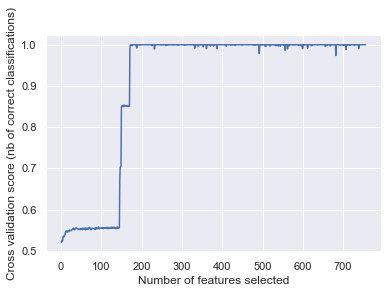

(94445, 174)


In [29]:
# 再帰的特徴除去
def plot_rfecv(selector):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set()

    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
    plt.show()
    plt.clf()
    plt.close()


if __name__ == '__main__':    
    X_train = df_all.loc[df_all["y"].notnull()]
    cate_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.to_list()
    for col in cate_cols:
        X_train[col], uni = pd.factorize(X_train[col])
    y_train = X_train["y"]

    best_params = {'bagging_fraction': 0.9, 'bagging_freq': 6, 'feature_fraction': 0.1, 'max_depth': 7, 'min_child_samples': 343, 'min_child_weight': 0.04084861948055769, 'num_leaves': 95, 'reg_alpha': 0.5612212694825488, 'reg_lambda': 0.0001757886119766502}
    clf = lgb.LGBMClassifier(n_jobs=-1, seed=71, **best_params)  # 欠損ある場合はGBM使う（リッジより遅い）

    # RFECVは交差検証+再帰的特徴除去。データでかいとメモリ死ぬので注意
    # RFE（再帰的特徴除去=recursive feature elimination: すべての特徴量を使う状態から、1つずつ特徴量を取り除いていく）で特徴量選択
    selector = RFECV(clf, cv=KFold(3, shuffle=True), scoring="accuracy", n_jobs=-1)
    selector.fit(X_train, y_train)

    # 選択した特徴量
    select_cols = X_train.columns[selector.get_support()].to_list()
    print("\nselect_cols:\n", select_cols, len(select_cols))
    # 捨てた特徴量
    print("not select_cols:\n", X_train.columns[~selector.get_support()].to_list())
    plot_rfecv(selector)

    select_cols.append("y")
    pd.DataFrame({"select_cols": select_cols}).to_csv(f"{OUT_DATA}/rfecv_select_cols.csv", index=False)
    df_all[select_cols].to_csv(f"{OUT_DATA}/rfecv.csv", index=False)
    print(df_all[select_cols].shape)

In [30]:
df_all = pd.read_csv(f"{OUT_DATA}/eng3.csv", index_col=0)

# label_encoding
cate_cols = df_all.select_dtypes(include=["object", "category", "bool"]).columns.to_list()
for col in cate_cols:
    df_all[col], uni = pd.factorize(df_all[col])
print(df_all.shape)

(94445, 756)


In [31]:
def count_encoder(train_df, valid_df, cat_features=None):
    """
    Count_Encoding: カテゴリ列をカウント値に変換する特徴量エンジニアリング（要はgroupby().size()の集計列追加のこと）
    ※カウント数が同じカテゴリは同じようなデータ傾向になる可能性がある
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    # conda install -c conda-forge category_encoders
    import category_encoders as ce

    if cat_features is None:
        cat_features = train_df.select_dtypes(
            include=["object", "category", "bool"]
        ).columns.to_list()

    count_enc = ce.CountEncoder(cols=cat_features)

    # trainだけでfitすること(validationやtest含めるとリークする)
    count_enc.fit(train_df[cat_features])
    train_encoded = train_df.join(
        count_enc.transform(train_df[cat_features]).add_suffix("_count")
    )
    valid_encoded = valid_df.join(
        count_enc.transform(valid_df[cat_features]).add_suffix("_count")
    )

    return train_encoded, valid_encoded


def target_encoder(train_df, valid_df, target_col: str, cat_features=None):
    """
    Target_Encoding: カテゴリ列を目的変数の平均値に変換する特徴量エンジニアリング
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    # conda install -c conda-forge category_encoders
    import category_encoders as ce

    if cat_features is None:
        cat_features = train_df.select_dtypes(
            include=["object", "category", "bool"]
        ).columns.to_list()

    target_enc = ce.TargetEncoder(cols=cat_features)

    # trainだけでfitすること(validationやtest含めるとリークする)
    target_enc.fit(train_df[cat_features], train_df[target_col])

    train_encoded = train_df.join(
        target_enc.transform(train_df[cat_features]).add_suffix("_target")
    )
    valid_encoded = valid_df.join(
        target_enc.transform(valid_df[cat_features]).add_suffix("_target")
    )
    return train_encoded, valid_encoded


def catboost_encoder(train_df, valid_df, target_col: str, cat_features=None):
    """
    CatBoost_Encoding: カテゴリ列を目的変数の1行前の行からのみに変換する特徴量エンジニアリング
    CatBoost使ったターゲットエンコーディング
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    # conda install -c conda-forge category_encoders
    import category_encoders as ce

    if cat_features is None:
        cat_features = train_df.select_dtypes(
            include=["object", "category", "bool"]
        ).columns.to_list()

    cb_enc = ce.CatBoostEncoder(cols=cat_features, random_state=7)

    # trainだけでfitすること(validationやtest含めるとリークする)
    cb_enc.fit(train_df[cat_features], train_df[target_col])

    train_encoded = train_df.join(
        cb_enc.transform(train_df[cat_features]).add_suffix("_cb")
    )
    valid_encoded = valid_df.join(
        cb_enc.transform(valid_df[cat_features]).add_suffix("_cb")
    )
    return train_encoded, valid_encoded


def _enc(tr_df, te_df, dict_enc_flag={"count": True, "target": True, "catboost": True}):
    if dict_enc_flag["count"]:
        # カウントエンコディング
        tr_df, te_df = count_encoder(tr_df, te_df, cat_features=None)
    if dict_enc_flag["target"]:
        # ターゲットエンコディング
        tr_df, te_df = target_encoder(tr_df, te_df, target_col="y", cat_features=None)
    if dict_enc_flag["catboost"]:
        # CatBoostエンコディング
        tr_df, te_df = catboost_encoder(tr_df, te_df, target_col="y", cat_features=None)
    # ラベルエンコディング
    cate_cols = tr_df.select_dtypes(include=["object", "category", "bool"]).columns.to_list()
    for col in cate_cols:
        tr_df[col], uni = pd.factorize(tr_df[col])
        te_df[col], uni = pd.factorize(te_df[col])
    return tr_df, te_df


def run_feature_selection(df, target_col, params,):
    """feature_importanceの閾値固定して特徴量選択"""
    # 特徴量の列名（取捨選択前）
    input_cols = df.columns.tolist()
    n_before_selection = len(input_cols)
    input_cols.remove(target_col)

    # 特徴量選択用モデル取得
    lgbm_params = {
        "objective": params["objective"],
        "metric": params["metric"],
        "verbosity": -1,
    }
    selector = GBDTFeatureSelector(
        input_cols=input_cols,
        target_col=target_col,
        threshold=params["threshold"],
        lgbm_params=lgbm_params,
    )
    selector.fit(df)

    # 選択をした特徴量を返す
    selected_cols = selector.get_selected_cols()
    print(f" - {n_before_selection - len(selected_cols)} features are removed.")
    return df[selected_cols]


if __name__ == '__main__':
    df_all = pd.read_csv(f"{OUT_DATA}/eng2.csv", index_col=0)
    target_col = "y"

    # target encording
    df = df_all[df_all[target_col].notnull()]
    (X_train, X_test, y_train, y_test) = train_test_split(
        df.drop(target_col, axis=1), 
        df[target_col], 
        test_size=0.1, 
        random_state=71
    )
    train_df = pd.concat([X_train, y_train], axis=1)
    valid_df = pd.concat([X_test, y_test], axis=1)
    train_df, _ = _enc(train_df, valid_df)
    print(train_df.shape)

    # feature_importance高い順に列数を 列数*threshold にする
    n_cols = 300 #150
    threshold = n_cols / train_df.shape[1]
    params = {"metric": "binary_logloss", "objective": "binary", "threshold": threshold}  # metric=roc_aucでも可能
    select_df = run_feature_selection(train_df, target_col, params)
    print(select_df.shape)
    print(select_df.columns)

    # 列名保持
    feature_selections = sorted(select_df.columns.to_list())
    feature_selections.append(target_col)
    pd.DataFrame({"feature_selections": feature_selections}).to_csv(f"{OUT_DATA}/feature_selection_cols.csv", index=False)
    
    not_feature_selections = list(set(train_df.columns.to_list()) - set(feature_selections))  
    pd.DataFrame({"not_feature_selections": not_feature_selections}).to_csv(f"{OUT_DATA}/not_feature_selection_cols.csv", index=False)
    print(df_all.shape)

(59494, 442)
 - 143 features are removed.
(59494, 299)
Index(['B3-weapon_target', 'A2-weapon_target', 'A1-weapon_target',
       'A4-weapon_target', 'B2-weapon_target', 'diff_AB-level_sum',
       'B4-weapon_target', 'A3-weapon_target', 'B1-weapon_target',
       'diff_AB-rank_sum',
       ...
       'B1-category1_B1-weapon_freq1name', 'A3-category2_A3-weapon_freq1name',
       'B3-rank_B3-weapon_count', 'B2-category1_B2-weapon_freq1ratio',
       'A1-category1_A1-weapon_freq_entropy',
       'A2-category1_A2-weapon_freq1name', 'B3-category1_B3-weapon_count',
       'B3-category2_B3-weapon_freq1name',
       'B3-category1_B3-weapon_freq_entropy', 'B3-category2_B3-weapon_count'],
      dtype='object', length=299)
(94445, 289)


In [33]:
dic = {"a": 122}
"b" in dic

False